# Helpers

## Packages

In [ ]:
install.packages("writexl")
install.packages("svglite")

In [1]:
library(tidyverse)
library(bigrquery)
library(writexl)
library(readxl)
library(ggplot2)
library(scales)  # For comma formatting
library(data.table)
library(lubridate)
library(svglite)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘packa

## Functions

In [2]:
summarize_na <- function(df_covariates, df_y = NULL, rule = FALSE) {
  # Get total number of rows
  total_rows <- nrow(df_covariates)
  
  # Initialize empty data frame
  df_cov_amount <- data.frame(
    covariate = character(ncol(df_covariates)),
    missing = numeric(ncol(df_covariates)),
    present = numeric(ncol(df_covariates)),
    missing_in_positive = numeric(ncol(df_covariates))
  )
  
  colnames(df_cov_amount) <- c("covariate", "missing", "present", "missing_in_positive")
  
  # Populate the data frame
  df_cov_amount$covariate <- colnames(df_covariates)
  df_cov_amount$missing <- colSums(is.na(df_covariates))
  df_cov_amount$present <- total_rows - df_cov_amount$missing
  

    
  # Calculate missing in positive class if df_y is provided
  if (!is.null(df_y)) {
    df_merged <- inner_join(df_covariates, df_y, by = eid) %>% filter(status == 1)
    df_cov_amount$missing_in_positive <- colSums(is.na(df_merged))
  } else {
    df_cov_amount$missing_in_positive <- NA
  }
  
  if (rule) {
    # Apply the "<20" rule
    apply_rule <- function(x) {
      ifelse(is.na(x), NA, ifelse(x < 20, "<20", as.character(x)))
    }
    
    df_cov_amount$missing <- apply_rule(df_cov_amount$missing)
    df_cov_amount$present <- apply_rule(df_cov_amount$present)
    df_cov_amount$missing_in_positive <- apply_rule(df_cov_amount$missing_in_positive)
    
    # Convert columns to character type
    df_cov_amount$missing <- as.character(df_cov_amount$missing)
    df_cov_amount$present <- as.character(df_cov_amount$present)
    df_cov_amount$missing_in_positive <- as.character(df_cov_amount$missing_in_positive)
  }
  
  print(paste("Total rows:", total_rows))
  if (!is.null(df_y)) {
    print(paste("Positive cases:", sum(df_y$status == 1)))
  }
  if (rule) {
    print("Note: Values below 20 are reported as '<20' to comply with All of Us regulations.")
  }
  
  return(df_cov_amount)
}

check_missing_positives <- function(df, rule_status=TRUE) {

    df_merged <- inner_join(df, df_y, by = eid) %>% filter(status == 1)
    diag_na <- summarize_na(df_merged, rule=rule_status)
    print(diag_na)  
}


impute_continuous <- function(data) {
  # Loop through all columns except 'eid'
  for(col in setdiff(names(data), "eid")) {
    # Check if the column is numeric (continuous)
    if(is.numeric(data[[col]])) {
      # Calculate median only if there are NA values to replace
      if(any(is.na(data[[col]]))) {
        med_val <- median(data[[col]], na.rm = TRUE)
        data[[col]][is.na(data[[col]])] <- med_val
      }
    }
  }
  return(data)
}

impute_categorical <- function(data) {
  # Function to calculate mode
  get_mode <- function(x) {
    ux <- unique(x)
    ux[which.max(tabulate(match(x, ux)))]
  }
  
  # Loop through all columns except 'eid'
  for(col in setdiff(names(data), "eid")) {
    # Check if the column is a factor or character (categorical)
    if(is.factor(data[[col]]) || is.character(data[[col]])) {
      # Calculate mode only if there are NA values to replace
      if(any(is.na(data[[col]]))) {
        mode_val <- get_mode(data[[col]][!is.na(data[[col]])])
        data[[col]][is.na(data[[col]])] <- mode_val
      }
    }
  }
  return(data)
}

# Function to impute both continuous and categorical variables
impute_all <- function(data) {
  data <- impute_continuous(data)
  data <- impute_categorical(data)
  return(data)
}


minmax <- function(x, na.rm = TRUE) {
  return((x- min(x, na.rm = na.rm)) /(max(x, na.rm = na.rm)-min(x, na.rm = na.rm)))
}



DOI <- "HCC"


extract_year <- function(datetime_str) {
  if (is.na(datetime_str)) {
    return(NA)
  }
  
  # Try parsing with lubridate
  parsed_date <- ymd_hms(datetime_str, quiet = TRUE)
  if (!is.na(parsed_date)) {
    return(year(parsed_date))
  }
  
  # If parsing fails, try extracting year with regex
  year_match <- str_extract(datetime_str, "\\d{4}")
  if (!is.na(year_match)) {
    return(as.numeric(year_match))
  }
  
  # If all else fails, return NA
  return(NA)
}

# Covariates

## Date of primary consent

### Export

In [ ]:
library(tidyverse)
library(bigrquery)

# Get date of primary consent
# - https://support.researchallofus.org/hc/en-us/articles/13176125767188-How-to-find-participant-enrollment-data
# - use to compute age from dob

DATASET <- Sys.getenv('WORKSPACE_CDR')

primary_consent_date_df <- bq_table_download(bq_project_query(
    Sys.getenv("GOOGLE_PROJECT"), page_size = 25000,
    query = str_glue("
-- Compute the count of unique participants in our All of Us cohort.
SELECT DISTINCT
    person_id,
    MIN(observation_date) AS primary_consent_date
FROM 
    `{DATASET}.concept`
JOIN 
    `{DATASET}.concept_ancestor` 
        ON concept_id = ancestor_concept_id
JOIN 
    `{DATASET}.observation` 
        ON descendant_concept_id = observation_source_concept_id
WHERE 
    concept_name = 'Consent PII' AND concept_class_id = 'Module'
GROUP BY 1
")))

head(primary_consent_date_df)
str(primary_consent_date_df)

In [ ]:
ls()
str(primary_consent_date_df)

### Process

In [ ]:
dim(primary_consent_date_df)
min(primary_consent_date_df$primary_consent_date)

print(paste("NAs in 'Date of attending' Spalte: ", sum(is.na(primary_consent_date_df$`primary_consent_date`))))

print(paste("Out of range from 2006-today: ", sum(primary_consent_date_df$`primary_consent_date` < as.Date("2006-01-01") | 
    primary_consent_date_df$`primary_consent_date` > Sys.Date())))

print(paste("Inconsistent format: ", sum(as.character(primary_consent_date_df$`primary_consent_date`, format = "%Y-%m-%d") != primary_consent_date_df$`primary_consent_date`)))

df_covariates <- primary_consent_date_df

write.table(df_covariates, "Jan/HCC_covariates_1.1.txt", sep="\t", quote=F, row.names=F)


## Age and  Sex

### Extract

In [ ]:
library(tidyverse)
library(bigrquery)

# This query represents dataset "Jan_HCC_Covariates" for domain "person" and was generated for All of Us Controlled Tier Dataset v7
dataset_03039562_person_sql <- paste("
    SELECT
        person.person_id,
        person.gender_concept_id,
        p_gender_concept.concept_name as gender,
        person.birth_datetime as date_of_birth,
        person.race_concept_id,
        p_race_concept.concept_name as race,
        person.ethnicity_concept_id,
        p_ethnicity_concept.concept_name as ethnicity,
        person.sex_at_birth_concept_id,
        p_sex_at_birth_concept.concept_name as sex_at_birth 
    FROM
        `person` person 
    LEFT JOIN
        `concept` p_gender_concept 
            ON person.gender_concept_id = p_gender_concept.concept_id 
    LEFT JOIN
        `concept` p_race_concept 
            ON person.race_concept_id = p_race_concept.concept_id 
    LEFT JOIN
        `concept` p_ethnicity_concept 
            ON person.ethnicity_concept_id = p_ethnicity_concept.concept_id 
    LEFT JOIN
        `concept` p_sex_at_birth_concept 
            ON person.sex_at_birth_concept_id = p_sex_at_birth_concept.concept_id", sep="")

# Formulate a Cloud Storage destination path for the data exported from BigQuery.
# NOTE: By default data exported multiple times on the same day will overwrite older copies.
#       But data exported on a different days will write to a new location so that historical
#       copies can be kept as the dataset definition is changed.
person_03039562_path <- file.path(
  Sys.getenv("WORKSPACE_BUCKET"),
  "bq_exports",
  Sys.getenv("OWNER_EMAIL"),
  strftime(lubridate::now(), "%Y%m%d"),  # Comment out this line if you want the export to always overwrite.
  "person_03039562",
  "person_03039562_*.csv")
message(str_glue('The data will be written to {person_03039562_path}. Use this path when reading ',
                 'the data into your notebooks in the future.'))

# Perform the query and export the dataset to Cloud Storage as CSV files.
# NOTE: You only need to run `bq_table_save` once. After that, you can
#       just read data from the CSVs in Cloud Storage.
bq_table_save(
  bq_dataset_query(Sys.getenv("WORKSPACE_CDR"), dataset_03039562_person_sql, billing = Sys.getenv("GOOGLE_PROJECT")),
  person_03039562_path,
  destination_format = "CSV")



In [ ]:
library(tidyverse)

# Read the data directly from Cloud Storage into memory.
# NOTE: Alternatively you can `gsutil -m cp {person_03039562_path}` to copy these files
#       to the Jupyter disk.
read_bq_export_from_workspace_bucket <- function(export_path) {
  col_types <- cols(gender = col_character(), race = col_character(), ethnicity = col_character(), sex_at_birth = col_character())
  bind_rows(
    map(system2('gsutil', args = c('ls', export_path), stdout = TRUE, stderr = TRUE),
        function(csv) {
          message(str_glue('Loading {csv}.'))
          chunk <- read_csv(pipe(str_glue('gsutil cat {csv}')), col_types = col_types, show_col_types = FALSE)
          if (is.null(col_types)) {
            col_types <- spec(chunk)
          }
          chunk
        }))
}
#person_03039562_path <- "gs://fc-secure-b96fb036-3379-4be0-8834-e7e486f2b76e/bq_exports/davidz1@researchallofus.org/20240509/person_03039562/person_03039562_*.csv"
person_03039562_path <- "gs://fc-secure-7ce90512-cbaf-4591-985d-a48ed28a7fda/bq_exports/janclusmann@researchallofus.org/20240730/person_03039562/person_03039562_*.csv"
dataset_03039562_person_df <- read_bq_export_from_workspace_bucket(person_03039562_path)

dim(dataset_03039562_person_df)

head(dataset_03039562_person_df, 5)

### Process

In [ ]:
unique(dataset_03039562_person_df$race)
unique(dataset_03039562_person_df$ethnicity)
race_counts <- table(dataset_03039562_person_df$race)

# Get the proportions
race_proportions <- prop.table(race_counts)

# Combine counts and proportions into a data frame
race_summary <- data.frame(
  Count = race_counts,
  Proportion = race_proportions
)

# Print the result
print(race_summary)
race_summary <- race_summary[order(-race_summary$Count.Var1),]
pie(race_counts, main="Proportion of Races")

# Further preprocessing of race/ethnicity see "Ethnicity Processing"

In [ ]:
df_covariates <- data.table::fread("HCC/HCC_covariates_1.1.txt", sep="\t")
head(df_covariates)

In [ ]:
df_covariates <- data.table::fread("HCC/HCC_covariates_1.1.txt", sep="\t")
dim(df_covariates)

dataset_03039562_person_df <- dataset_03039562_person_df %>%
    select(person_id, date_of_birth, sex_at_birth, race)

df_covariates <- merge(df_covariates, dataset_03039562_person_df, by="person_id")
df_covariates$date_of_birth <- as.Date(df_covariates$date_of_birth)
df_covariates$primary_consent_date <- as.Date(df_covariates$primary_consent_date)
df_covariates$AGE <- as.numeric(difftime(df_covariates$primary_consent_date, df_covariates$date_of_birth, unit="days"))/365.25

df_covariates <- df_covariates %>%
    select(-date_of_birth)

# df_covariates$AGE_cat <- cut(df_covariates$AGE,
#                         breaks = c(0, 10, 20, 30, 40, 50, 60, 70, 80, 90, max(df_covariates$AGE)),
#                         labels = c("0-10", "10-20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-80", "80-90", ">90"))
# table(df_covariates$AGE_cat, useNA = "ifany")

df_covariates <- df_covariates %>%
    rename(SEX = sex_at_birth) %>%
    filter(SEX %in% c("Female","Male"))

table(df_covariates$SEX)

dim(df_covariates)
head(df_covariates)

#df_covariates$SEX <- factor(df_covariates$SEX, levels = c(0, 1), labels = c("Female", "Male"))

#levels(df_covariates$SEX)

write.table(df_covariates, "HCC/HCC_covariates_1.2.txt", sep="\t", quote=F, row.names=F)


## BMI, Height, Weight, Waist, BP

### Extract

In [ ]:
library(tidyverse)
library(bigrquery)

# This query represents dataset "Jan_HCC_Covariates" for domain "measurement" and was generated for All of Us Controlled Tier Dataset v7
dataset_35873912_measurement_sql <- paste("
    SELECT
        measurement.person_id,
        measurement.measurement_concept_id,
        m_standard_concept.concept_name as standard_concept_name,
        m_standard_concept.concept_code as standard_concept_code,
        m_standard_concept.vocabulary_id as standard_vocabulary,
        measurement.measurement_datetime,
        measurement.measurement_type_concept_id,
        m_type.concept_name as measurement_type_concept_name,
        measurement.operator_concept_id,
        m_operator.concept_name as operator_concept_name,
        measurement.value_as_number,
        measurement.value_as_concept_id,
        m_value.concept_name as value_as_concept_name,
        measurement.unit_concept_id,
        m_unit.concept_name as unit_concept_name,
        measurement.range_low,
        measurement.range_high,
        measurement.visit_occurrence_id,
        m_visit.concept_name as visit_occurrence_concept_name,
        measurement.measurement_source_value,
        measurement.measurement_source_concept_id,
        m_source_concept.concept_name as source_concept_name,
        m_source_concept.concept_code as source_concept_code,
        m_source_concept.vocabulary_id as source_vocabulary,
        measurement.unit_source_value,
        measurement.value_source_value 
    FROM
        ( SELECT
            * 
        FROM
            `measurement` measurement 
        WHERE
            (
                measurement_source_concept_id IN (SELECT
                    DISTINCT c.concept_id 
                FROM
                    `cb_criteria` c 
                JOIN
                    (SELECT
                        CAST(cr.id as string) AS id       
                    FROM
                        `cb_criteria` cr       
                    WHERE
                        concept_id IN (903107, 903115, 903118, 903121, 903124, 903133, 903135)       
                        AND full_text LIKE '%_rank1]%'      ) a 
                        ON (c.path LIKE CONCAT('%.', a.id, '.%') 
                        OR c.path LIKE CONCAT('%.', a.id) 
                        OR c.path LIKE CONCAT(a.id, '.%') 
                        OR c.path = a.id) 
                WHERE
                    is_standard = 0 
                    AND is_selectable = 1)
            )) measurement 
    LEFT JOIN
        `concept` m_standard_concept 
            ON measurement.measurement_concept_id = m_standard_concept.concept_id 
    LEFT JOIN
        `concept` m_type 
            ON measurement.measurement_type_concept_id = m_type.concept_id 
    LEFT JOIN
        `concept` m_operator 
            ON measurement.operator_concept_id = m_operator.concept_id 
    LEFT JOIN
        `concept` m_value 
            ON measurement.value_as_concept_id = m_value.concept_id 
    LEFT JOIN
        `concept` m_unit 
            ON measurement.unit_concept_id = m_unit.concept_id 
    LEFT JOIn
        `visit_occurrence` v 
            ON measurement.visit_occurrence_id = v.visit_occurrence_id 
    LEFT JOIN
        `concept` m_visit 
            ON v.visit_concept_id = m_visit.concept_id 
    LEFT JOIN
        `concept` m_source_concept 
            ON measurement.measurement_source_concept_id = m_source_concept.concept_id", sep="")

# Formulate a Cloud Storage destination path for the data exported from BigQuery.
# NOTE: By default data exported multiple times on the same day will overwrite older copies.
#       But data exported on a different days will write to a new location so that historical
#       copies can be kept as the dataset definition is changed.
measurement_35873912_path <- file.path(
  Sys.getenv("WORKSPACE_BUCKET"),
  "bq_exports",
  Sys.getenv("OWNER_EMAIL"),
  strftime(lubridate::now(), "%Y%m%d"),  # Comment out this line if you want the export to always overwrite.
  "measurement_35873912",
  "measurement_35873912_*.csv")
message(str_glue('The data will be written to {measurement_35873912_path}. Use this path when reading ',
                 'the data into your notebooks in the future.'))

# Perform the query and export the dataset to Cloud Storage as CSV files.
# NOTE: You only need to run `bq_table_save` once. After that, you can
#       just read data from the CSVs in Cloud Storage.
bq_table_save(
  bq_dataset_query(Sys.getenv("WORKSPACE_CDR"), dataset_35873912_measurement_sql, billing = Sys.getenv("GOOGLE_PROJECT")),
  measurement_35873912_path,
  destination_format = "CSV")



In [ ]:
# Read the data directly from Cloud Storage into memory.
# NOTE: Alternatively you can `gsutil -m cp {measurement_35873912_path}` to copy these files
#       to the Jupyter disk.
read_bq_export_from_workspace_bucket <- function(export_path) {
  col_types <- cols(standard_concept_name = col_character(), standard_concept_code = col_character(), standard_vocabulary = col_character(), measurement_type_concept_name = col_character(), operator_concept_name = col_character(), value_as_concept_name = col_character(), unit_concept_name = col_character(), visit_occurrence_concept_name = col_character(), measurement_source_value = col_character(), source_concept_name = col_character(), source_concept_code = col_character(), source_vocabulary = col_character(), unit_source_value = col_character(), value_source_value = col_character())
  bind_rows(
    map(system2('gsutil', args = c('ls', export_path), stdout = TRUE, stderr = TRUE),
        function(csv) {
          message(str_glue('Loading {csv}.'))
          chunk <- read_csv(pipe(str_glue('gsutil cat {csv}')), col_types = col_types, show_col_types = FALSE)
          if (is.null(col_types)) {
            col_types <- spec(chunk)
          }
          chunk
        }))
}

#measurement_35873912_path <- "gs://fc-secure-b96fb036-3379-4be0-8834-e7e486f2b76e/bq_exports/davidz1@researchallofus.org/20240517/measurement_35873912/measurement_35873912_*.csv"
measurement_35873912_path <- "gs://fc-secure-b96fb036-3379-4be0-8834-e7e486f2b76e/bq_exports/davidz1@researchallofus.org/20240517/measurement_35873912/measurement_35873912_*.csv"

dataset_35873912_measurement_df <- read_bq_export_from_workspace_bucket(measurement_35873912_path)

dim(dataset_35873912_measurement_df)

head(dataset_35873912_measurement_df, 5)

### Process

In [ ]:
df_covariates <- data.table::fread("HCC/HCC_covariates_1.2.txt", sep="\t")
dim(df_covariates)

measurement_df <- dataset_35873912_measurement_df %>%
    select(person_id, standard_concept_name, value_as_number) %>%
    filter(standard_concept_name != "Computed blood pressure systolic and diastolic, mean of 2nd and 3rd measures")

measurement_df$standard_concept_name[measurement_df$standard_concept_name == "Body height"] <- "Standing height"
measurement_df$standard_concept_name[measurement_df$standard_concept_name == "Body mass index (BMI) [Ratio]"] <- "BMI"
measurement_df$standard_concept_name[measurement_df$standard_concept_name == "Computed systolic blood pressure, mean of 2nd and 3rd measures"] <- "SBP"
measurement_df$standard_concept_name[measurement_df$standard_concept_name == "Computed diastolic blood pressure, mean of 2nd and 3rd measures"] <- "DBP"
measurement_df$standard_concept_name[measurement_df$standard_concept_name == "Computed waist circumference, mean of closest two measures"] <- "Waist circumference"
measurement_df$standard_concept_name[measurement_df$standard_concept_name == "Body weight"] <- "Weight"

measurement_df <- pivot_wider(measurement_df, names_from = standard_concept_name, values_from = value_as_number)

df_covariates <- merge(df_covariates, measurement_df, by="person_id")

dim(df_covariates)
head(df_covariates)

### Impute by calculation
bmi_NA <- sum(is.na(df_covariates$BMI))
print(paste("Number of NA values in BMI before imputation:", bmi_NA))

df_covariates$BMI[is.na(df_covariates$`BMI`) & !is.na(df_covariates$Weight) & !is.na(df_covariates$`Standing height`)] <- df_covariates$Weight[is.na(df_covariates$`BMI`) & !is.na(df_covariates$Weight) & !is.na(df_covariates$`Standing height`)] / (df_covariates$`Standing height`[is.na(df_covariates$`BMI`) & !is.na(df_covariates$Weight) & !is.na(df_covariates$`Standing height`)]/100)^2
bmi_NA <- sum(is.na(df_covariates$BMI))
print(paste("Number of NA values in BMI after manual calculation:", bmi_NA))

### Impute by waist circumference in categories
df_covariates$BMI_cat <- cut(df_covariates$BMI,
                        breaks = c(0, 18.5, 24.9, 29.9, max(df_covariates$BMI, na.rm=T)),
                        labels = c("Underweight", "Normal weight", "Overweight", "Obese"))
bmi_NA <- sum(is.na(df_covariates$BMI) & !is.na(df_covariates$`Waist circumference`))
print(paste("Number of NA values that could be imputed by estimation from Waist circumference:", bmi_NA))

### ********** CHANGED SEX *************** ###
#Label as obese or normal according to WHO definition
df_covariates$BMI_cat[is.na(df_covariates$BMI_cat) & (df_covariates$`Waist circumference` >= 80) & (df_covariates$SEX == "Female")] <- "Obese"
df_covariates$BMI_cat[is.na(df_covariates$BMI_cat) & (df_covariates$`Waist circumference` < 80) & (df_covariates$SEX == "Female")] <- "Normal weight"
df_covariates$BMI_cat[is.na(df_covariates$BMI_cat) & (df_covariates$`Waist circumference` >= 94) & (df_covariates$SEX == "Male")] <- "Obese"
df_covariates$BMI_cat[is.na(df_covariates$BMI_cat) & (df_covariates$`Waist circumference` < 94) & (df_covariates$SEX == "Male")] <- "Normal weight"

# Calculate mean for Group "Normal weight" and "Obese" according to waist circumference and Sex
normal_men <- mean(df_covariates$BMI[df_covariates$BMI_cat == "Normal weight" & df_covariates$SEX=="Male"], na.rm=TRUE)
normal_women <- mean(df_covariates$BMI[df_covariates$BMI_cat == "Normal weight" & df_covariates$SEX=="Female"], na.rm=TRUE)
obese_men <- mean(df_covariates$BMI[df_covariates$BMI_cat == "Obese" & df_covariates$SEX=="Male"], na.rm=TRUE)
obese_women <- mean(df_covariates$BMI[df_covariates$BMI_cat == "Obese" & df_covariates$SEX=="Female"], na.rm=TRUE)

#Store mean of groups normal/obese for men/women (Not great but better than just mean imputing)
df_covariates$BMI[is.na(df_covariates$BMI) & !is.na(df_covariates$`Waist circumference`) & df_covariates$SEX== "Male"] <- ifelse(df_covariates$BMI_cat[is.na(df_covariates$BMI) & !is.na(df_covariates$`Waist circumference`) & df_covariates$SEX== "Male"] == "Normal weight", normal_men, obese_men) 
df_covariates$BMI[is.na(df_covariates$BMI) & !is.na(df_covariates$`Waist circumference`) & df_covariates$SEX== "Female"] <- ifelse(df_covariates$BMI_cat[is.na(df_covariates$BMI) & !is.na(df_covariates$`Waist circumference`) & df_covariates$SEX== "Female"] == "Normal weight", normal_women, obese_women) 

bmi_NA <- sum(is.na(df_covariates$BMI))
print(paste("Number of NA values after imputation from Waist circumference:", bmi_NA))

dim(df_covariates)
head(df_covariates)

#dim(df_covariates[complete.cases(df_covariates[,c("BMI", "Waist circumference", "Weight", "Standing height")]), ])
#df_covariates <- df_covariates[complete.cases(df_covariates[,c("BMI", "Waist circumference", "Weight", "Standing height")]), ]

write.table(df_covariates, "HCC/HCC_covariates_1.3.txt", sep="\t", quote=F, row.names=F)


## Smoking

### Extract

In [ ]:
library(tidyverse)
library(bigrquery)

# This query represents dataset "Jan_HCC_Smoking" for domain "survey" and was generated for All of Us Controlled Tier Dataset v7
dataset_22980624_survey_sql <- paste("
    SELECT
        answer.person_id,
        answer.survey_datetime,
        answer.survey,
        answer.question_concept_id,
        answer.question,
        answer.answer_concept_id,
        answer.answer,
        answer.survey_version_concept_id,
        answer.survey_version_name  
    FROM
        `ds_survey` answer   
    WHERE
        (
            question_concept_id IN (1585857, 1585860, 1585873, 1586159, 1586162)
        )", sep="")

# Formulate a Cloud Storage destination path for the data exported from BigQuery.
# NOTE: By default data exported multiple times on the same day will overwrite older copies.
#       But data exported on a different days will write to a new location so that historical
#       copies can be kept as the dataset definition is changed.
survey_22980624_path <- file.path(
  Sys.getenv("WORKSPACE_BUCKET"),
  "bq_exports",
  Sys.getenv("OWNER_EMAIL"),
  strftime(lubridate::now(), "%Y%m%d"),  # Comment out this line if you want the export to always overwrite.
  "survey_22980624",
  "survey_22980624_*.csv")
message(str_glue('The data will be written to {survey_22980624_path}. Use this path when reading ',
                 'the data into your notebooks in the future.'))

# Perform the query and export the dataset to Cloud Storage as CSV files.
# NOTE: You only need to run `bq_table_save` once. After that, you can
#       just read data from the CSVs in Cloud Storage.
bq_table_save(
  bq_dataset_query(Sys.getenv("WORKSPACE_CDR"), dataset_22980624_survey_sql, billing = Sys.getenv("GOOGLE_PROJECT")),
  survey_22980624_path,
  destination_format = "CSV")



In [ ]:
# Read the data directly from Cloud Storage into memory.
# NOTE: Alternatively you can `gsutil -m cp {survey_22980624_path}` to copy these files
#       to the Jupyter disk.
read_bq_export_from_workspace_bucket <- function(export_path) {
  col_types <- cols(survey = col_character(), question = col_character(), answer = col_character(), survey_version_name = col_character())
  bind_rows(
    map(system2('gsutil', args = c('ls', export_path), stdout = TRUE, stderr = TRUE),
        function(csv) {
          message(str_glue('Loading {csv}.'))
          chunk <- read_csv(pipe(str_glue('gsutil cat {csv}')), col_types = col_types, show_col_types = FALSE)
          if (is.null(col_types)) {
            col_types <- spec(chunk)
          }
          chunk
        }))
}
survey_22980624_path <- "gs://fc-secure-b96fb036-3379-4be0-8834-e7e486f2b76e/bq_exports/davidz1@researchallofus.org/20240517/survey_22980624/survey_22980624_*.csv"
dataset_22980624_survey_df <- read_bq_export_from_workspace_bucket(survey_22980624_path)

dim(dataset_22980624_survey_df)

head(dataset_22980624_survey_df, 5)

### Process

In [ ]:
df_covariates <- data.table::fread("Jan/HCC_covariates_1.3.txt", sep="\t")
head(df_covariates)

survey_df <- dataset_22980624_survey_df %>%
    select(person_id, question, answer)

survey_df$question[survey_df$question == "Smoking: 100 Cigs Lifetime"] <- "Ever smoked"
survey_df$question[survey_df$question == "Smoking: Smoke Frequency"] <- "Smoking status"
survey_df$question[survey_df$question == "Smoking: Average Daily Cigarette Number"] <- "Avg daily"
survey_df$question[survey_df$question == "Smoking: Current Daily Cigarette Number"] <- "Current daily"
survey_df$question[survey_df$question == "Smoking: Number Of Years"] <- "Years"

survey_df <- pivot_wider(survey_df, names_from = question, values_from = answer)

df_covariates <- merge(df_covariates, survey_df, by="person_id")

# Change ever smoked to yes, no, NA (we don't know)
df_covariates$`Ever smoked`[df_covariates$`Ever smoked` == "100 Cigs Lifetime: Yes"] <- "Yes"
df_covariates$`Ever smoked`[df_covariates$`Ever smoked` == "100 Cigs Lifetime: No"] <- "No"
df_covariates$`Ever smoked`[grepl("PMI", df_covariates$`Ever smoked`)] <- NA

# Change avg daily and years to NA if no answer (there's no way to impute)
df_covariates$`Avg daily`[grepl("PMI", df_covariates$`Avg daily`)] <- NA
df_covariates$`Years`[grepl("PMI", df_covariates$`Years`)] <- NA

# Compute pack years
df_covariates$`Pack years` <- NA
df_covariates$`Pack years`[!is.na(df_covariates$`Avg daily`) & !is.na(df_covariates$`Years`)] <- (as.numeric(df_covariates$`Avg daily`[!is.na(df_covariates$`Avg daily`) & !is.na(df_covariates$`Years`)]) / 20) * 
                                                                                                           as.numeric(df_covariates$`Years`[!is.na(df_covariates$`Avg daily`) & !is.na(df_covariates$`Years`)])
quantile(df_covariates$`Pack years`, na.rm=T)

#Impute ever smoked (is NA - no way of knowing)
df_covariates$`Ever smoked`[is.na(df_covariates$`Ever smoked`) & df_covariates$`Pack years` >= 0] <- "Yes"
df_covariates$`Ever smoked`[is.na(df_covariates$`Ever smoked`) & df_covariates$`Smoking status` != "Never"] <- "Yes"
df_covariates$`Ever smoked`[is.na(df_covariates$`Ever smoked`) & df_covariates$`Current daily` > 0] <- "Yes"
#df_covariates$`Ever smoked`[is.na(df_covariates$`Ever smoked`)] <- "No"
#table(df_covariates$`Ever smoked`, useNA = "ifany")

# Impute smoking status
df_covariates$`Smoking status`[df_covariates$`Smoking status` == "Smoke Frequency: Every Day"] <- "Current"
df_covariates$`Smoking status`[df_covariates$`Smoking status` == "Smoke Frequency: Some Days"] <- "Current"
df_covariates$`Smoking status`[df_covariates$`Smoking status` == "Smoke Frequency: Not At All"] <- "Previous"
df_covariates$`Smoking status`[grepl("PMI", df_covariates$`Smoking status`)] <- "Previous"
df_covariates$`Smoking status`[df_covariates$`Ever smoked` == "Yes" & is.na(df_covariates$`Smoking status`)] <- "Previous"
df_covariates$`Smoking status`[df_covariates$`Ever smoked` == "No" & is.na(df_covariates$`Smoking status`)] <- "Never"

#Pack years = 0 imputed from Smoking status=never or Ever smoked=No
df_covariates$`Pack years`[df_covariates$`Ever smoked` == "No" | df_covariates$`Smoking status` == "Never"] <- 0 

#All others have smoking = yes and will get the mean Pack years
print(paste0("Mean pack years: ", mean(df_covariates$`Pack years`, na.rm=T)))
df_covariates$`Pack years`[is.na(df_covariates$`Pack years`) & !is.na(df_covariates$`Ever smoked`)] <- mean(df_covariates$`Pack years`, na.rm=T)
quantile(df_covariates$`Pack years`, na.rm=T)

#############################
### Should missing smoking also get mean pack years? for now no - can add later or just remove pts
#############################

df_covariates <- df_covariates %>%
    select(-`Avg daily`, -`Current daily`, -`Years`)

sum(is.na(df_covariates$`Smoking status`))
sum(is.na(df_covariates$`Ever smoked`))
sum(is.na(df_covariates$`Pack years`))

#set factors with labels/levels
#df_covariates["Ever smoked"] <- factor(df_covariates$`Ever smoked`, levels=c(0, 1), labels = c("No", "Yes"))
#df_covariates["Smoking status"] <- factor(df_covariates$`Smoking status`, levels=c(0, 1, 2), labels = c("Never", "Previous", "Current"))

dim(df_covariates)
head(df_covariates)


In [ ]:
adjust_outliers <- function(df, column_name) {
    # Ensure the column exists in the dataframe
    if (!column_name %in% colnames(df)) {
        stop(paste("Column", column_name, "does not exist in the dataframe"))
    }

    # Calculate the 99th percentile
    quantile_999 <- quantile(df[[column_name]], 0.999, na.rm = TRUE)

    # Identify outliers
    outliers <- df[[column_name]] > quantile_999
    outliers_count <- sum(outliers, na.rm = TRUE)
    outliers_range <- range(df[[column_name]][outliers], na.rm = TRUE)

    # Replace outliers with the 99th percentile value
    df[[column_name]] <- ifelse(outliers, quantile_999, df[[column_name]])

    # Print the range of values that were cut
    cat("Outliers detected and adjusted to the 99th percentile limit:\n")
    cat("Number of outliers:", outliers_count, "\n")
    cat("Range of outliers:", outliers_range, "\n")
    cat("99.9th percentile limit:", quantile_999, "\n")

    return(df)
}

df_covariates <- adjust_outliers(df_covariates, 'Pack years')

quantile(df_covariates$`Pack years`, na.rm=T)

dim(df_covariates)
head(df_covariates)

write.table(df_covariates, "Jan/HCC_covariates_1.4.txt", sep="\t", quote=F, row.names=F)


In [ ]:
quantile(df_covariates$`Pack years`, na.rm=T)
quantile(test$`Pack years`, na.rm=T)


## Alcohol

### Extract

In [ ]:
library(tidyverse)
library(bigrquery)

# This query represents dataset "Jan_HCC_Alcohol" for domain "survey" and was generated for All of Us Controlled Tier Dataset v7
dataset_05380700_survey_sql <- paste("
    SELECT
        answer.person_id,
        answer.survey_datetime,
        answer.survey,
        answer.question_concept_id,
        answer.question,
        answer.answer_concept_id,
        answer.answer,
        answer.survey_version_concept_id,
        answer.survey_version_name  
    FROM
        `ds_survey` answer   
    WHERE
        (
            question_concept_id IN (1586198, 1586201, 1586207, 1586213)
        )", sep="")

# Formulate a Cloud Storage destination path for the data exported from BigQuery.
# NOTE: By default data exported multiple times on the same day will overwrite older copies.
#       But data exported on a different days will write to a new location so that historical
#       copies can be kept as the dataset definition is changed.
survey_05380700_path <- file.path(
  Sys.getenv("WORKSPACE_BUCKET"),
  "bq_exports",
  Sys.getenv("OWNER_EMAIL"),
  strftime(lubridate::now(), "%Y%m%d"),  # Comment out this line if you want the export to always overwrite.
  "survey_05380700",
  "survey_05380700_*.csv")
message(str_glue('The data will be written to {survey_05380700_path}. Use this path when reading ',
                 'the data into your notebooks in the future.'))

# Perform the query and export the dataset to Cloud Storage as CSV files.
# NOTE: You only need to run `bq_table_save` once. After that, you can
#       just read data from the CSVs in Cloud Storage.
bq_table_save(
  bq_dataset_query(Sys.getenv("WORKSPACE_CDR"), dataset_05380700_survey_sql, billing = Sys.getenv("GOOGLE_PROJECT")),
  survey_05380700_path,
  destination_format = "CSV")



In [ ]:
# Read the data directly from Cloud Storage into memory.
# NOTE: Alternatively you can `gsutil -m cp {survey_05380700_path}` to copy these files
#       to the Jupyter disk.
read_bq_export_from_workspace_bucket <- function(export_path) {
  col_types <- cols(survey = col_character(), question = col_character(), answer = col_character(), survey_version_name = col_character())
  bind_rows(
    map(system2('gsutil', args = c('ls', export_path), stdout = TRUE, stderr = TRUE),
        function(csv) {
          message(str_glue('Loading {csv}.'))
          chunk <- read_csv(pipe(str_glue('gsutil cat {csv}')), col_types = col_types, show_col_types = FALSE)
          if (is.null(col_types)) {
            col_types <- spec(chunk)
          }
          chunk
        }))
}
survey_05380700_path <- "gs://fc-secure-b96fb036-3379-4be0-8834-e7e486f2b76e/bq_exports/davidz1@researchallofus.org/20240523/survey_05380700/survey_05380700_*.csv"
dataset_05380700_survey_df <- read_bq_export_from_workspace_bucket(survey_05380700_path)

dim(dataset_05380700_survey_df)

head(dataset_05380700_survey_df, 5)

### Process

In [ ]:
df_covariates <- data.table::fread("Jan/HCC_covariates_1.4.txt", sep="\t")
head(df_covariates)

survey_df <- dataset_05380700_survey_df %>%
    select(person_id, question, answer)

survey_df$question[survey_df$question == "Alcohol: Alcohol Participant"] <- "Ever drank"
survey_df$question[survey_df$question == "Alcohol: Drink Frequency Past Year"] <- "Past year"
survey_df$question[survey_df$question == "Alcohol: Average Daily Drink Count"] <- "Avg daily"
survey_df$question[survey_df$question == "Alcohol: 6 or More Drinks Occurrence"] <- "More six"

survey_df <- pivot_wider(survey_df, names_from = question, values_from = answer)

df_covariates <- merge(df_covariates, survey_df, by="person_id")

# Rename `Past year`
df_covariates$`Past year`[df_covariates$`Past year` == "Drink Frequency Past Year: Never"] <- 0
df_covariates$`Past year`[df_covariates$`Past year` == "Drink Frequency Past Year: Monthly Or Less"] <- 1/4.345
df_covariates$`Past year`[df_covariates$`Past year` == "Drink Frequency Past Year: 2 to 4 Per Month"] <- 3/4.345
df_covariates$`Past year`[df_covariates$`Past year` == "Drink Frequency Past Year: 2 to 3 Per Week"] <- 2.5
df_covariates$`Past year`[df_covariates$`Past year` == "Drink Frequency Past Year: 4 or More Per Week"] <- 4
df_covariates$`Past year`[grepl("PMI", df_covariates$`Past year`)] <- NA

# Rename `Avg daily`
df_covariates$`Avg daily`[df_covariates$`Avg daily` == "Average Daily Drink Count: 1 or 2"] <- 1.5
df_covariates$`Avg daily`[df_covariates$`Avg daily` == "Average Daily Drink Count: 3 or 4"] <- 3.5
df_covariates$`Avg daily`[df_covariates$`Avg daily` == "Average Daily Drink Count: 5 or 6"] <- 5.5
df_covariates$`Avg daily`[df_covariates$`Avg daily` == "Average Daily Drink Count: 7 to 9"] <- 8
df_covariates$`Avg daily`[df_covariates$`Avg daily` == "Average Daily Drink Count: 10 or More"] <- 10
df_covariates$`Avg daily`[grepl("PMI", df_covariates$`Avg daily`)] <- NA

# Compute alk_g_d
df_covariates$`Alk_g_d` <- NA
df_covariates$`Alk_g_d`[!is.na(df_covariates$`Past year`) & !is.na(df_covariates$`Avg daily`)] <- 
    as.numeric(df_covariates$`Past year`[!is.na(df_covariates$`Past year`) & !is.na(df_covariates$`Avg daily`)]) * 
    as.numeric(df_covariates$`Avg daily`[!is.na(df_covariates$`Past year`) & !is.na(df_covariates$`Avg daily`)]) *
    14 / 7
df_covariates$`Alk_g_d`[df_covariates$`Ever drank` == "Alcohol Participant: No"] <- 0
df_covariates$`Alk_g_d`[df_covariates$`Past year` == 0] <- 0
# Otherwise keep NA if missing - if they prefer not to answer, we cannot make assumption

df_covariates <- df_covariates %>%
    select(-`Ever drank`, -`Past year`, -`Avg daily`, -`More six`)

quantile(df_covariates$`Alk_g_d`, na.rm=T)

dim(df_covariates)
head(df_covariates)


In [ ]:
adjust_outliers <- function(df, column_name) {
    # Ensure the column exists in the dataframe
    if (!column_name %in% colnames(df)) {
        stop(paste("Column", column_name, "does not exist in the dataframe"))
    }

    # Calculate the 99th percentile
    quantile_999 <- quantile(df[[column_name]], 0.999, na.rm = TRUE)

    # Identify outliers
    outliers <- df[[column_name]] > quantile_999
    outliers_count <- sum(outliers, na.rm = TRUE)
    outliers_range <- range(df[[column_name]][outliers], na.rm = TRUE)

    # Replace outliers with the 99th percentile value
    df[[column_name]] <- ifelse(outliers, quantile_999, df[[column_name]])

    # Print the range of values that were cut
    cat("Outliers detected and adjusted to the 99th percentile limit:\n")
    cat("Number of outliers:", outliers_count, "\n")
    cat("Range of outliers:", outliers_range, "\n")
    cat("99.9th percentile limit:", quantile_999, "\n")

    return(df)
}

df_covariates <- adjust_outliers(df_covariates, 'Alk_g_d')

# WHO's gender-specific limits
df_covariates$Path_Alk <- ifelse(df_covariates$SEX == "Male", df_covariates$`Alk_g_d` / 60, df_covariates$`Alk_g_d` / 40)
df_covariates$Path_Alk <- ifelse(df_covariates$Path_Alk >= 1, 1, ifelse(df_covariates$Path_Alk < 0.9999999999, 0, df_covariates$Path_Alk))
df_covariates$High_Alk <- ifelse(df_covariates$SEX == "Male", df_covariates$`Alk_g_d` / 24, df_covariates$`Alk_g_d` / 12)
df_covariates$High_Alk <- ifelse(df_covariates$High_Alk >= 1, 1, ifelse(df_covariates$High_Alk < 0.9999999999, 0, df_covariates$High_Alk))

dim(df_covariates)
head(df_covariates)

write.table(df_covariates, "Jan/HCC_covariates_1.5.txt", sep="\t", quote=F, row.names=F)

sum(!is.na(df_covariates$`Alk_g_d`) & df_covariates$`Alk_g_d` > 0)
quantile(df_covariates$`Alk_g_d`, na.rm=T)
mean(df_covariates$`Alk_g_d`, na.rm=T)
sd(df_covariates$`Alk_g_d`, na.rm=T)


## Deprivation index

### Extract

In [ ]:
library(tidyverse)
library(bigrquery)

# This query represents dataset "Jan_HCC_Deprivation" for domain "zip_code_socioeconomic" and was generated for All of Us Controlled Tier Dataset v7
dataset_14505310_zip_code_socioeconomic_sql <- paste("
    SELECT
        observation.person_id,
        observation.observation_datetime,
        zip_code.zip3_as_string as zip_code,
        zip_code.fraction_assisted_income as assisted_income,
        zip_code.fraction_high_school_edu as high_school_education,
        zip_code.median_income,
        zip_code.fraction_no_health_ins as no_health_insurance,
        zip_code.fraction_poverty as poverty,
        zip_code.fraction_vacant_housing as vacant_housing,
        zip_code.deprivation_index,
        zip_code.acs as american_community_survey_year 
    FROM
        `zip3_ses_map` zip_code 
    JOIN
        `observation` observation 
            ON CAST(SUBSTR(observation.value_as_string, 0, STRPOS(observation.value_as_string, '*') - 1) AS INT64) = zip_code.zip3 
            AND observation_source_concept_id = 1585250 
            AND observation.value_as_string NOT LIKE 'Res%'", sep="")

# Formulate a Cloud Storage destination path for the data exported from BigQuery.
# NOTE: By default data exported multiple times on the same day will overwrite older copies.
#       But data exported on a different days will write to a new location so that historical
#       copies can be kept as the dataset definition is changed.
zip_code_socioeconomic_14505310_path <- file.path(
  Sys.getenv("WORKSPACE_BUCKET"),
  "bq_exports",
  Sys.getenv("OWNER_EMAIL"),
  strftime(lubridate::now(), "%Y%m%d"),  # Comment out this line if you want the export to always overwrite.
  "zip_code_socioeconomic_14505310",
  "zip_code_socioeconomic_14505310_*.csv")
message(str_glue('The data will be written to {zip_code_socioeconomic_14505310_path}. Use this path when reading ',
                 'the data into your notebooks in the future.'))

# Perform the query and export the dataset to Cloud Storage as CSV files.
# NOTE: You only need to run `bq_table_save` once. After that, you can
#       just read data from the CSVs in Cloud Storage.
bq_table_save(
  bq_dataset_query(Sys.getenv("WORKSPACE_CDR"), dataset_14505310_zip_code_socioeconomic_sql, billing = Sys.getenv("GOOGLE_PROJECT")),
  zip_code_socioeconomic_14505310_path,
  destination_format = "CSV")



In [ ]:
# Read the data directly from Cloud Storage into memory.
# NOTE: Alternatively you can `gsutil -m cp {zip_code_socioeconomic_14505310_path}` to copy these files
#       to the Jupyter disk.
read_bq_export_from_workspace_bucket <- function(export_path) {
  col_types <- cols(zip3_as_string = col_character())
  bind_rows(
    map(system2('gsutil', args = c('ls', export_path), stdout = TRUE, stderr = TRUE),
        function(csv) {
          message(str_glue('Loading {csv}.'))
          chunk <- read_csv(pipe(str_glue('gsutil cat {csv}')), col_types = col_types, show_col_types = FALSE)
          if (is.null(col_types)) {
            col_types <- spec(chunk)
          }
          chunk
        }))
}
zip_code_socioeconomic_14505310_path <- "gs://fc-secure-b96fb036-3379-4be0-8834-e7e486f2b76e/bq_exports/davidz1@researchallofus.org/20240522/zip_code_socioeconomic_14505310/zip_code_socioeconomic_14505310_*.csv"
dataset_14505310_zip_code_socioeconomic_df <- read_bq_export_from_workspace_bucket(zip_code_socioeconomic_14505310_path)

dim(dataset_14505310_zip_code_socioeconomic_df)

head(dataset_14505310_zip_code_socioeconomic_df, 5)

### Process

In [ ]:
df_covariates <- data.table::fread("Jan/HCC_covariates_1.5.txt", sep="\t")
head(df_covariates)

dep_idx <- dataset_14505310_zip_code_socioeconomic_df %>%
    select(person_id, deprivation_index)

df_covariates <- merge(df_covariates, dep_idx, by="person_id")

dim(df_covariates)
head(df_covariates)

write.table(df_covariates, "Jan/HCC_covariates_1.6.txt", sep="\t", quote=F, row.names=F)


## Medications

### Extract

In [ ]:
library(tidyverse)
library(bigrquery)

# This query represents dataset "Jan_HCC_Medications" for domain "survey" and was generated for All of Us Controlled Tier Dataset v7
dataset_00748392_survey_sql <- paste("
    SELECT
        answer.person_id,
        answer.survey_datetime,
        answer.survey,
        answer.question_concept_id,
        answer.question,
        answer.answer_concept_id,
        answer.answer,
        answer.survey_version_concept_id,
        answer.survey_version_name  
    FROM
        `ds_survey` answer   
    WHERE
        (
            question_concept_id IN (1384437, 1384641, 43528793, 43528819, 43528820, 836799, 836800)
        )", sep="")

# Formulate a Cloud Storage destination path for the data exported from BigQuery.
# NOTE: By default data exported multiple times on the same day will overwrite older copies.
#       But data exported on a different days will write to a new location so that historical
#       copies can be kept as the dataset definition is changed.
survey_00748392_path <- file.path(
  Sys.getenv("WORKSPACE_BUCKET"),
  "bq_exports",
  Sys.getenv("OWNER_EMAIL"),
  strftime(lubridate::now(), "%Y%m%d"),  # Comment out this line if you want the export to always overwrite.
  "survey_00748392",
  "survey_00748392_*.csv")
message(str_glue('The data will be written to {survey_00748392_path}. Use this path when reading ',
                 'the data into your notebooks in the future.'))

# Perform the query and export the dataset to Cloud Storage as CSV files.
# NOTE: You only need to run `bq_table_save` once. After that, you can
#       just read data from the CSVs in Cloud Storage.
bq_table_save(
  bq_dataset_query(Sys.getenv("WORKSPACE_CDR"), dataset_00748392_survey_sql, billing = Sys.getenv("GOOGLE_PROJECT")),
  survey_00748392_path,
  destination_format = "CSV")



In [ ]:
# Read the data directly from Cloud Storage into memory.
# NOTE: Alternatively you can `gsutil -m cp {survey_00748392_path}` to copy these files
#       to the Jupyter disk.
read_bq_export_from_workspace_bucket <- function(export_path) {
  col_types <- cols(survey = col_character(), question = col_character(), answer = col_character(), survey_version_name = col_character())
  bind_rows(
    map(system2('gsutil', args = c('ls', export_path), stdout = TRUE, stderr = TRUE),
        function(csv) {
          message(str_glue('Loading {csv}.'))
          chunk <- read_csv(pipe(str_glue('gsutil cat {csv}')), col_types = col_types, show_col_types = FALSE)
          if (is.null(col_types)) {
            col_types <- spec(chunk)
          }
          chunk
        }))
}
survey_00748392_path <- "gs://fc-secure-b96fb036-3379-4be0-8834-e7e486f2b76e/bq_exports/davidz1@researchallofus.org/20240523/survey_00748392/survey_00748392_*.csv"
dataset_00748392_survey_df <- read_bq_export_from_workspace_bucket(survey_00748392_path)

dim(dataset_00748392_survey_df)

head(dataset_00748392_survey_df, 5)

### Process

In [ ]:
df_covariates <- data.table::fread("Jan/HCC_covariates_1.6.txt", sep="\t")
head(df_covariates)

survey_df <- dataset_00748392_survey_df %>%
    select(person_id, question, answer)

survey_df$question[survey_df$question == "Are you currently prescribed medications and/or receiving treatment for high blood pressure (hypertension)?"] <- "HTN"
survey_df$question[survey_df$question == "Are you currently prescribed medications and/or receiving treatment for high cholesterol?"] <- "High Chol"
survey_df$question[survey_df$question == "Are you currently prescribed medications and/or receiving treatment for other hormone/endocrine condition(s)?"] <- "Hormone"
survey_df$question[survey_df$question == "Are you currently prescribed medications and/or receiving treatment for type 1 diabetes?"] <- "T1DM"
survey_df$question[survey_df$question == "Are you currently prescribed medications and/or receiving treatment for type 2 diabetes?"] <- "T2DM"
survey_df$question[survey_df$question == "Including yourself, who in your family has had type 1 diabetes? Select all that apply."] <- "T1DM Fam"
survey_df$question[survey_df$question == "Including yourself, who in your family has had type 2 diabetes? Select all that apply."] <- "T2DM Fam"

# Set NA responses to 0 as well
htn_ids <- survey_df$person_id[survey_df$question == "HTN" & survey_df$answer == "Are you currently prescribed medications and/or receiving treatment for high blood pressure (hypertension)? - Yes"]
chol_ids <- survey_df$person_id[survey_df$question == "High Chol" & survey_df$answer == "Are you currently prescribed medications and/or receiving treatment for high cholesterol? - Yes"]
t1dm_ids <- survey_df$person_id[survey_df$question == "T1DM" & survey_df$answer == "Are you currently prescribed medications and/or receiving treatment for type 1 diabetes? - Yes"]
t2dm_ids <- survey_df$person_id[survey_df$question == "T2DM" & survey_df$answer == "Are you currently prescribed medications and/or receiving treatment for type 2 diabetes? - Yes"]
metabolic_ids <- unique(c(htn_ids, chol_ids, t1dm_ids, t2dm_ids))
hormone_ids <- survey_df$person_id[survey_df$question == "Hormone" & survey_df$answer == "Are you currently prescribed medications and/or receiving treatment for other hormone/endocrine condition(s)? - Yes"]

df_covariates$Medication <- 0
df_covariates$Medication[df_covariates$person_id %in% metabolic_ids] <- 1
df_covariates$Medication[df_covariates$person_id %in% hormone_ids] <- 2
df_covariates$Medication <- factor(df_covariates$Medication, levels=c(0,1,2), labels= c("No Medication", "Metabolic", "Hormones"))

table(df_covariates$Medication)

# Family diabetes
t1dm_ids <- survey_df$person_id[survey_df$question == "T1DM Fam" &
                                (survey_df$answer == "Including yourself, who in your family has had type 1 diabetes? - Father" | 
                                 survey_df$answer == "Including yourself, who in your family has had type 1 diabetes? - Mother" |
                                 survey_df$answer == "Including yourself, who in your family has had type 1 diabetes? - Sibling")]
t2dm_ids <- survey_df$person_id[survey_df$question == "T2DM Fam" &
                                (survey_df$answer == "Including yourself, who in your family has had type 2 diabetes? - Father" | 
                                 survey_df$answer == "Including yourself, who in your family has had type 2 diabetes? - Mother" |
                                 survey_df$answer == "Including yourself, who in your family has had type 2 diabetes? - Sibling")]
dm_ids <- unique(c(t1dm_ids, t2dm_ids))

df_covariates$Family_diabetes <- 0
df_covariates$Family_diabetes[df_covariates$person_id %in% dm_ids] <- 1
df_covariates$Family_diabetes <- as.factor(df_covariates$Family_diabetes)

table(df_covariates$Family_diabetes)

dim(df_covariates)
head(df_covariates)

write.table(df_covariates, "Jan/HCC_covariates_1.7.txt", sep="\t", quote=F, row.names=F)


## Additional corrections

In [ ]:
df_covariates <- data.table::fread("HCC/HCC_covariates_1.7.txt", sep="\t")
df_covariates <- df_covariates %>% select(-(c("AGE_cat")))



#write.table(df_covariates, "HCC/HCC_covariates_1.7.txt", sep="\t", quote=F, row.names=F)

# ICD codes

## Process ICD codes for covariates

In [ ]:
library(tidyverse)

In [ ]:
icd_codes_subset <- data.table::fread("HCC/HCC_ICD_codes_subset.txt", sep="\t")

dim(icd_codes_subset)
head(icd_codes_subset)


In [ ]:
icd_codes_subset$source_concept_code <- gsub("\\.", "", icd_codes_subset$source_concept_code)
icd_codes_subset$source_concept_code <- substr(icd_codes_subset$source_concept_code, 1, 4)

head(icd_codes_subset)


In [ ]:
# ICD Groups
ICD_Groups <- data.table::fread("Jan/ICD_Groups.txt", sep="\t")

pat_icds_labelled <- left_join(x = ICD_Groups, y = icd_codes_subset %>% select(person_id, source_concept_code) %>% distinct(), 
                               by = c("ICD10" = "source_concept_code")) %>% 
                     distinct()

dim(pat_icds_labelled)
#head(pat_icds_labelled)

#Check for amount of diagnosis per actual ICD, instead of group. Likely here will be the correct amounts, while summarized will be less due to parallel coded diagnosis
df_icd_groups_before <- pat_icds_labelled %>% group_by(Diagnosis, person_id) %>% summarise(occurence = n()) %>% spread(Diagnosis, occurence) 
sum_groups_before <- as.data.frame(colSums(df_icd_groups_before, na.rm=TRUE))

head(sum_groups_before)

#Groupby + summarises
df_icd_groups <- pat_icds_labelled %>% group_by(Group, person_id) %>% summarise(occurence = n()) %>% spread(Group, occurence) 
df_icd_groups[df_icd_groups > 1 & df_icd_groups < 100]<- 1 
df_icd_groups[is.na(df_icd_groups)] <- 0
sum_groups_after <- as.data.frame(colSums(df_icd_groups))

head(sum_groups_before)


In [ ]:
# ICD Singles
ICD_Singles <- data.table::fread("Jan/ICD_Singles.txt", sep="\t")

pat_icds_labelled <- left_join(x = ICD_Singles, y = icd_codes_subset %>% select(person_id, source_concept_code) %>% distinct(), 
                               by = c("ICD10" = "source_concept_code"))%>% 
                     distinct() 

dim(pat_icds_labelled)

#Groupby + summarises
df_icd_singles <- pat_icds_labelled %>% group_by(Diagnosis, person_id) %>% summarise(occurence = n()) %>% spread(Diagnosis, occurence) 
df_icd_singles[df_icd_singles > 1 & df_icd_singles < 10000]<- 1 
df_icd_singles[is.na(df_icd_singles)] <- 0
sum_singles <- as.data.frame(colSums(df_icd_singles))

head(sum_singles)


In [ ]:
# DM ICD codes
icd_dm_codes <- data.table::fread("Jan/HCC_ICD_codes_DM.txt", sep="\t")

icd_dm <- icd_dm_codes %>%
    select(person_id) %>%
    distinct()
icd_dm$DM <- 1
icd_dm <- select(icd_dm, c(person_id, DM))

dim(icd_dm)
head(icd_dm)


In [ ]:
#Merging groups and singles
df_icd <- full_join(df_icd_singles, df_icd_groups, by = "person_id")
df_icd <- merge(df_icd, icd_dm, by="person_id", all=TRUE)
df_icd <- replace(df_icd, is.na(df_icd), 0)

dim(df_icd)
head(df_icd)

### Note:
### - person_id '0' represents all codes that had NO patients diagnosed


### Include 'control' patients - patients with no diagnoses
icd_person_ids <- read.table("data/AllofUs_v7_phenotype_icd_091223_person_ids.txt", sep="\t", header=T)

df_icd <- merge(df_icd, icd_person_ids, by="person_id", all=TRUE)
df_icd[is.na(df_icd)] <- 0

dim(df_icd)
head(df_icd)

write.table(df_icd, "Jan/HCC_df_diagnosis.txt", sep="\t", quote=F, row.names=F)


In [ ]:
#Summarize ICD codes
create_summary <- function(df) {
  total_rows <- nrow(df)
  summary_df <- df %>% 
    summarise(across(-person_id, ~sum(. == "1", na.rm = TRUE))) %>% 
    pivot_longer(everything(), names_to = "Diagnosis", values_to = "Occurrence") %>% 
    mutate(Percentage = (Occurrence / total_rows) * 100) %>%
    arrange(desc(Occurrence))
  
  as.data.frame(summary_df)
}

df_icd <- data.table::fread("HCC/HCC_df_diagnosis.txt", sep="\t")

sum_diagnosis <- create_summary(df_icd)
sum_diagnosis
sum_diagnosis_sorted <- sum_diagnosis[order(sum_diagnosis$Diagnosis), ]
sum_diagnosis_sorted


## Extract HCC cases/controls

In [3]:
icd_codes_subset <- data.table::fread("HCC/HCC_ICD_codes_subset.txt", sep="\t")

dim(icd_codes_subset)
head(icd_codes_subset)

icd_codes_subset$source_concept_code <- gsub("\\.", "", icd_codes_subset$source_concept_code)
icd_codes_subset$source_concept_code <- substr(icd_codes_subset$source_concept_code, 1, 4)

head(icd_codes_subset)

[1] 4826626      10

person_id,condition_start_datetime,condition_end_datetime,condition_type_concept_name,visit_occurrence_id,visit_occurrence_concept_name,source_concept_name,source_concept_code,source_vocabulary,condition_type
<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
8679559,2020-12-29 06:00:00 UTC,NA,Claim,4.2e+16,Inpatient Visit,"Anemia, unspecified",D64.9,ICD10CM,condition
1820872,2019-01-30 06:00:00 UTC,NA,Claim,4.2e+16,Inpatient Visit,Essential (primary) hypertension,I10,ICD10CM,condition
1441451,2022-04-18 06:00:00 UTC,NA,Claim,4.2e+16,Inpatient Visit,Hypercalcemia,E83.52,ICD10CM,condition
1830301,2020-10-10 06:00:00 UTC,NA,Claim,4.2e+16,Inpatient Visit,"Chronic kidney disease, stage 3 unspecified",N18.30,ICD10CM,condition
3398366,2021-06-21 06:00:00 UTC,NA,Claim,4.2e+16,Inpatient Visit,Gastro-esophageal reflux disease without esophagitis,K21.9,ICD10CM,condition
1441451,2022-04-18 06:00:00 UTC,NA,Claim,4.2e+16,Inpatient Visit,Hypercalcemia,E83.52,ICD10CM,condition


person_id,condition_start_datetime,condition_end_datetime,condition_type_concept_name,visit_occurrence_id,visit_occurrence_concept_name,source_concept_name,source_concept_code,source_vocabulary,condition_type
<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
8679559,2020-12-29 06:00:00 UTC,NA,Claim,4.2e+16,Inpatient Visit,"Anemia, unspecified",D649,ICD10CM,condition
1820872,2019-01-30 06:00:00 UTC,NA,Claim,4.2e+16,Inpatient Visit,Essential (primary) hypertension,I10,ICD10CM,condition
1441451,2022-04-18 06:00:00 UTC,NA,Claim,4.2e+16,Inpatient Visit,Hypercalcemia,E835,ICD10CM,condition
1830301,2020-10-10 06:00:00 UTC,NA,Claim,4.2e+16,Inpatient Visit,"Chronic kidney disease, stage 3 unspecified",N183,ICD10CM,condition
3398366,2021-06-21 06:00:00 UTC,NA,Claim,4.2e+16,Inpatient Visit,Gastro-esophageal reflux disease without esophagitis,K219,ICD10CM,condition
1441451,2022-04-18 06:00:00 UTC,NA,Claim,4.2e+16,Inpatient Visit,Hypercalcemia,E835,ICD10CM,condition


### Process HCC cases

In [4]:
HCC_cases <- icd_codes_subset[icd_codes_subset$source_concept_code == "C220",]
HCC_cases <- HCC_cases %>%
  mutate(condition_start_datetime = ymd_hms(condition_start_datetime))

# Filter for the first visit per unique person_id
HCC_cases_first_visit <- HCC_cases %>%
  group_by(person_id) %>%
  arrange(condition_start_datetime) %>%
  slice(1) %>%
  ungroup() %>%
  mutate(year = sapply(condition_start_datetime, extract_year))

# Check the result
print(paste("Original number of rows:", nrow(HCC_cases)))
print(paste("Number of rows after filtering:", nrow(HCC_cases_first_visit)))
print(paste("Number of unique person_ids:", n_distinct(HCC_cases_first_visit$person_id)))

# Optional: View the first few rows of the result

df_nan <- read_xlsx("HCC/df_nan.xlsx")
df_y <- data.table::fread("HCC/HCC_case_controls.txt", sep="\t")


# Inner_join on patients with all necessary data
HCC_cases_final <- HCC_cases_first_visit %>%
  inner_join(df_y[df_y$status == 1, ], by = "person_id")
nrow(HCC_cases_final)
head(HCC_cases_final)

# Create a dataframe of cases that were removed (here due to missing information)
df_discard <- df_y %>%
  filter(status == 1) %>%
  anti_join(df_nan, by = "person_id") %>%
  select(person_id)
print(paste("Number of discarded cases:", nrow(df_discard)))


HCC_cases_final <- HCC_cases_final %>%
  mutate(discard = ifelse(person_id %in% df_discard$person_id, 1, 0))

# Print summary of the new 'discard' column
print(table(HCC_cases_final$discard))

# Optional: View the first few rows of the updated HCC_cases_final
head(HCC_cases_final)


doi_included <- nrow(HCC_cases_final) - nrow(df_discard)
doi_discarded <- nrow(df_discard)
doi_included


[1] "Original number of rows: 16052"
[1] "Number of rows after filtering: 559"
[1] "Number of unique person_ids: 559"


[1] 559

person_id,condition_start_datetime,condition_end_datetime,condition_type_concept_name,visit_occurrence_id,visit_occurrence_concept_name,source_concept_name,source_concept_code,source_vocabulary,condition_type,year,status
<int>,<dttm>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>
1008793,2019-07-19 11:07:00,2019-07-19 11:07:00 UTC,EHR,3.5e+16,Outpatient Visit,Liver cell carcinoma,C220,ICD10CM,condition,2019,1
1011474,2018-06-15 06:58:00,NA,EHR encounter diagnosis,9.0e+15,Outpatient Visit,Liver cell carcinoma,C220,ICD10CM,condition,2018,1
1014402,2022-06-23 00:42:00,NA,Secondary Condition,NA,NA,Liver cell carcinoma,C220,ICD10CM,condition,2022,1
1019682,2017-09-06 00:00:00,2017-09-06 11:59:59 UTC,Secondary Condition,2.7e+16,Outpatient Visit,Liver cell carcinoma,C220,ICD10CM,condition,2017,1
1023131,2022-04-21 00:00:00,2022-04-21 11:59:59 UTC,No matching concept,2.7e+16,Outpatient Visit,Liver cell carcinoma,C220,ICD10CM,condition,2022,1
1026457,2018-11-20 09:59:00,2018-11-20 15:45:00 UTC,Primary Condition,7.0e+15,Outpatient Visit,Liver cell carcinoma,C220,ICD10CM,condition,2018,1


[1] "Number of discarded cases: 114"

  0   1 
445 114 


person_id,condition_start_datetime,condition_end_datetime,condition_type_concept_name,visit_occurrence_id,visit_occurrence_concept_name,source_concept_name,source_concept_code,source_vocabulary,condition_type,year,status,discard
<int>,<dttm>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>
1008793,2019-07-19 11:07:00,2019-07-19 11:07:00 UTC,EHR,3.5e+16,Outpatient Visit,Liver cell carcinoma,C220,ICD10CM,condition,2019,1,0
1011474,2018-06-15 06:58:00,NA,EHR encounter diagnosis,9.0e+15,Outpatient Visit,Liver cell carcinoma,C220,ICD10CM,condition,2018,1,0
1014402,2022-06-23 00:42:00,NA,Secondary Condition,NA,NA,Liver cell carcinoma,C220,ICD10CM,condition,2022,1,0
1019682,2017-09-06 00:00:00,2017-09-06 11:59:59 UTC,Secondary Condition,2.7e+16,Outpatient Visit,Liver cell carcinoma,C220,ICD10CM,condition,2017,1,0
1023131,2022-04-21 00:00:00,2022-04-21 11:59:59 UTC,No matching concept,2.7e+16,Outpatient Visit,Liver cell carcinoma,C220,ICD10CM,condition,2022,1,0
1026457,2018-11-20 09:59:00,2018-11-20 15:45:00 UTC,Primary Condition,7.0e+15,Outpatient Visit,Liver cell carcinoma,C220,ICD10CM,condition,2018,1,1


[1] 445

### Plot HCC Cases

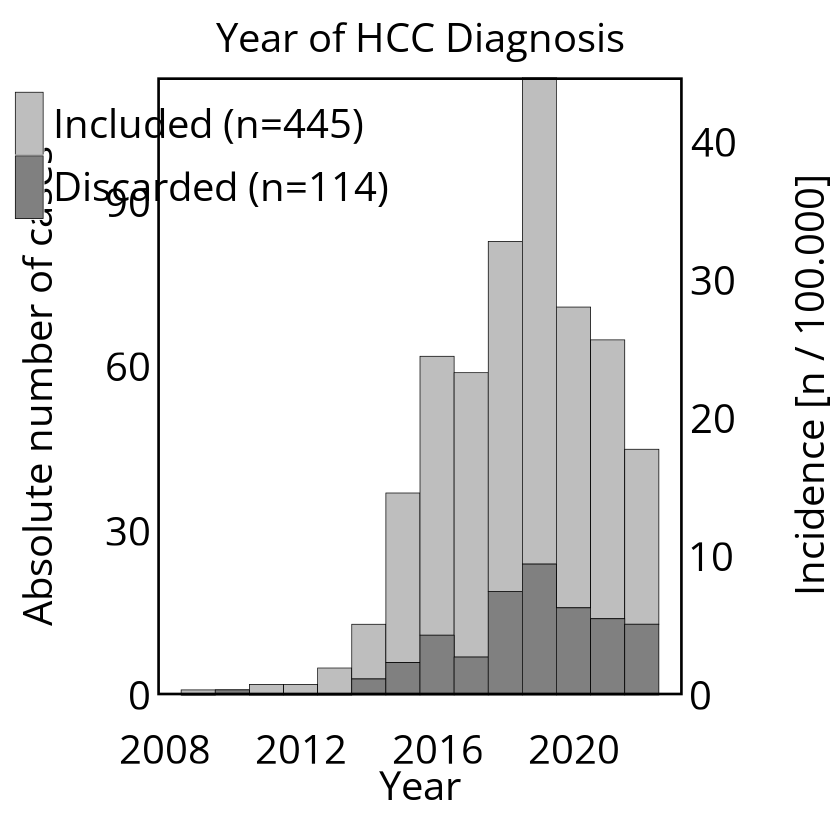

In [9]:
if (!requireNamespace("systemfonts", quietly = TRUE)) install.packages("systemfonts")
if (!requireNamespace("showtext", quietly = TRUE)) install.packages("showtext")
library(systemfonts)
library(showtext)

n_total <- nrow(df_y) #Assess absolute number

plot_included_discarded_cases <- function(df, base_size = 18, n_total) {
    if (systemfonts::system_fonts() %>% filter(family == "Arial") %>% nrow() > 0) {
    font_family <- "Arial"
  } else {
    font_family <- "Open Sans"
    font_add_google("Open Sans", "Open Sans")
  }
  
  showtext_auto()
  doi_included <- get("doi_included", envir = .GlobalEnv)
  doi_discarded <- get("doi_discarded", envir = .GlobalEnv)
  included_label <- paste("Included (n=", doi_included, ")", sep = "") # Custom labels for the legend
  discarded_label <- paste("Discarded (n=", doi_discarded, ")", sep = "")

  plot <- ggplot(df, aes(x = year, fill = as.factor(discard))) +
    geom_histogram(binwidth = 1, color = "black", size=0.2, width= 0.5) +
    scale_fill_manual(values = c("grey", "#808080"), 
                      labels = c(included_label, discarded_label), 
                      name = "") + 
    
    xlab("Year") +
    ylab("Absolute number of cases") +
    ggtitle(paste("Year of", DOI, "Diagnosis")) +
    theme_minimal(base_family = font_family) +
    theme(text = element_text(family = font_family),
          plot.title = element_text(hjust = 0.5, size = base_size), # Increase size to 150% 
          legend.position = c(0.3, 0.9), # upper left corner
          axis.title.x = element_text(size = base_size), 
          axis.title.y = element_text(size = base_size),
          axis.title.y.right = element_text(size = base_size, angle=90, vjust=-0.5),
          axis.text.y.right = element_text(size = base_size, colour = "black"),
          legend.text = element_text(size = base_size), 
          axis.text.x = element_text(size = base_size, colour="black", vjust=0.1), 
          axis.text.y = element_text(size = base_size, colour="black"),
          panel.grid.major = element_blank(), # Remove major grid lines
          panel.grid.minor = element_blank(), # Remove minor grid lines
          plot.margin = margin(0.5, 0.5, 0.5, 0.5, "cm"),
          panel.border = element_rect(colour = "black", fill = NA, linewidth = 1.5),
          legend.spacing.y = unit(2, "cm"),
          legend.key = element_rect(colour = "white", fill = NA)) +
  scale_y_continuous(
      expand = c(0, 0), 
      limits = c(0, NA),
      sec.axis = sec_axis(
        ~. / n_total * 100000,
        name = "Incidence [n / 100.000]"
      )
    )
  guides(fill = guide_legend(override.aes = list(colour = "white")))
  
  print(plot)
  ggsave(filename = "HCC/HCC_yearly_cases.svg", plot = plot, width = 10, height = 10, bg = "transparent")
  
  }

plot_included_discarded_cases(HCC_cases_final, base_size=30, n_total = n_total)


[1] 252804

## Explore diseases underlying HCC cases

### Rank priority of diagnosis

In [ ]:
### Function to plot stacked bar charts


stacked_bars_time_comparison <- function(df, base_size=18) {
  priority_order <- c("Cirrhosis", "Viral Hepatitis", "CLD", "No Liver disease")
  
  df <- df %>%
    mutate(Priority = priority(Group)) %>%
    arrange(Time, Priority) %>%
    group_by(Time) %>%
    mutate(LabelPos = cumsum(Count) - 0.5 * Count) %>% # Calculate label positions on cumulative sum column for label positioning
    ungroup() %>%
    mutate(Group = factor(Group, levels = priority_order))
  print(head(df))
  
  max_x_value <- max(as.numeric(as.factor(df$Time))) + 1
  df$max_x <- max_x_value  # add max_x to the dataframe
  
  label_data <- df %>%
    filter(Order == 2) %>%
    distinct(Group, .keep_all = TRUE)
  
  plot <- ggplot(data = df, aes(x = Time, y = Count, fill = Group)) +
    geom_bar(stat = "identity", position = position_stack(vjust = 0.5, reverse = TRUE), width=0.55 ) +
    geom_text(aes(label = Count, y = LabelPos), size = base_size * 0.4, colour = "black", vjust = -0.3) +
    geom_text(aes(label = sprintf("%.0f%%", Percentage), y = LabelPos), size = base_size * 0.3, colour = "black", vjust = 1.2) +
    geom_text(data = distinct(label_data, Group, .keep_all = TRUE), 
              aes(x = max_x - 0.4, label = Group, y = LabelPos), hjust=0, size = base_size * 0.4, color = "black") +
    theme_minimal() +
    labs(title = "Etiology Over Time",
         y = "Count") +
    scale_fill_brewer(palette = "Set3") +
    theme(plot.title = element_text(size=base_size, hjust = 0.5),
          axis.title.x =element_blank(),
          axis.title.y = element_blank(),
          legend.title = element_blank(),
          legend.position = "none",
          axis.text.x = element_text(size = base_size, colour = "black"),
          axis.text.y = element_blank(),
          panel.grid.major = element_blank(), # Remove major grid lines
          panel.grid.minor = element_blank(), # Remove minor grid lines
          plot.margin = margin(1, 300, 1, 10)) +
    coord_cartesian(clip = 'off')

  print(plot)
  #print(df)
  ggsave(filename = paste0(DOI, "/HCC_etiology_over_time.svg")), 
         plot = plot, width = 8, height = 10, bg = "transparent")
}


In [ ]:
priority_order <- c("Cirrhosis", "Viral Hepatitis", "CLD", "No Liver disease")

pat_cld <- pat_icds[pat_icds$diag_icd10 %in% par_icd_codes | pat_icds$diag_icd9 %in% par_icd_codes, ] %>%
  select(c("eid", "diag_icd9", "diag_icd10", "epistart")) %>%
  left_join(Patients_at_risk, by = c("diag_icd10" = "ICD10")) %>%
  right_join(df_y, by = "eid") %>%
  subset(status==1) %>%
  select(-c("location_name", "location_code", "location_nr", "location_country", "country_code", "split_ext", "split_int"))

pat_cld$epistart[is.na(pat_cld$Group)] <- as.Date(pat_cld$date_of_diag)

pat_cld$Group[is.na(pat_cld$Group)] <- "No Liver disease"
pat_cld$Group[!pat_cld$Group %in% par_subset] <- "No Liver disease" #Replace all non-matching groups with "No LD"
pat_cld$Group <- factor(pat_cld$Group, levels=priority_order)

summary(pat_cld$Group)

priority <- function(diagnosis) {
  case_when(
    diagnosis == "Cirrhosis" ~ 1,
    diagnosis == "Viral Hepatitis" ~ 2,
    diagnosis == "CLD" ~ 3,
    diagnosis == "No Liver disease" ~ 4,
    TRUE ~ 5  # Assign a lower priority to other diagnoses
  )
}


pat_cld <- pat_cld %>%
  group_by(eid)

# Node 0 represents first visit to hospital after assessment
pat_cld_node0 <- pat_cld %>%
  mutate(Priority = priority(Group)) %>%
  group_by(eid) %>%
  filter(epistart == min(epistart)) %>%
  arrange(eid, Priority) %>%
  filter(row_number() == 1) %>%
  ungroup() %>%
  select(-Priority)

summary_node0 <- pat_cld_node0 %>%
  group_by(Group) %>%
  summarize(Count = n(), .groups = 'drop') %>%
  mutate(Time = "First \nEHR") %>%
  mutate(Order = 1 ) %>%
  mutate(Priority = priority(Group)) %>%
  arrange(Priority) %>%
  mutate(Percentage = round(Count / sum(Count) * 100)) 



pat_cld_node1 <- pat_cld %>%
  mutate(Priority = priority(Group)) %>%
  group_by(eid) %>%
  #filter(epistart == max(epistart)) %>%   #better to take all incidents than just the last, as not all diags get coded everytime
  arrange(eid, Priority) %>%
  filter(row_number() == 1) %>%
  ungroup() %>%
  select(-Priority)

summary_node1 <- pat_cld_node1 %>%
  group_by(Group) %>%
  summarize(Count = n(), .groups = 'drop') %>%
  mutate(Time = paste0("Prior to\n", DOI)) %>%
  mutate(Order = 2 ) %>%
  mutate(Priority = priority(Group)) %>%
  arrange(Priority) %>%
  mutate(Percentage = round(Count / sum(Count) * 100))


# View the summaries
print(summary_node0)
print(summary_node1)


# Merge timepoints
combined_data <- rbind(summary_node0, summary_node1)


stacked_bars_time_comparison(combined_data, base_size=22)







## Explore Cirrhosis

In [44]:
check_unique_participants <- function(df, name) {
  total_rows <- nrow(df)
  unique_participants <- n_distinct(df$person_id)
  print(paste("Checking", name))
  print(paste("Total rows:", total_rows))
  print(paste("Unique participants:", unique_participants))
}


# Check cirrhosis_cases and HCC_cases
check_unique_participants(cirrhosis_cases, "Cirrhosis Cases")
check_unique_participants(HCC_cases, "HCC Cases")


process_icd_codes <- function(icd_codes_subset, codes, disease_name, select_visits = "first") {
  # Filter for the specified ICD codes
  cases <- icd_codes_subset[icd_codes_subset$source_concept_code %in% codes, ]
  
  # Convert condition_start_datetime to datetime format
  cases <- cases %>%
    mutate(condition_start_datetime = ymd_hms(condition_start_datetime))
  
  # Function to extract year from datetime
  extract_year <- function(date) {
    return(year(date))
  }
  
  # Process based on select_visits option
  if (select_visits == "first") {
    # Filter for the first visit per unique person_id
    processed_cases <- cases %>%
      group_by(person_id) %>%
      arrange(condition_start_datetime) %>%
      slice(1) %>%
      ungroup()
  } else if (select_visits == "all") {
    # Keep all visits
    processed_cases <- cases
  } else {
    stop("Invalid select_visits option. Use 'first' or 'all'.")
  }
  
  # Add year and date_of_diag columns
  processed_cases <- processed_cases %>%
    mutate(
      year = sapply(condition_start_datetime, extract_year),
      date_of_diag = as.Date(condition_start_datetime)
    )
  
  # Add disease name column
  processed_cases$disease <- disease_name
  
  # Print summary information
  print(paste("Processing", disease_name, "cases:"))
  print(paste("ICD codes used:", paste(codes, collapse = ", ")))
  print(paste("Original number of rows:", nrow(cases)))
  print(paste("Number of rows after processing:", nrow(processed_cases)))
  print(paste("Number of unique person_ids:", n_distinct(processed_cases$person_id)))
  
  # Optional: Count of cases per ICD code
  if (length(codes) > 1) {
    code_counts <- processed_cases %>%
      group_by(source_concept_code) %>%
      summarise(count = n()) %>%
      arrange(desc(count))
    print("Cases per ICD code:")
    print(code_counts)
  }
    
  processed_cases <- processed_cases %>% select(c("person_id", "source_concept_code", "date_of_diag", "disease"))
  return(processed_cases)
}

cirrhosis_codes <- c("K703", "K743", "K745", "K746", "K767", "I850", "I859", "R18")


cirrhosis_cases <- process_icd_codes(icd_codes_subset, cirrhosis_codes, "Cirrhosis", "first")

HCC_cases <- process_icd_codes(icd_codes_subset, "C220", "HCC", "first")


check_unique_participants(cirrhosis_cases, "Cirrhosis Cases")
check_unique_participants(HCC_cases, "HCC Cases")


head(cirrhosis_cases)
head(HCC_cases)
dim(cirrhosis_cases)
dim(HCC_cases)


[1] "Checking Cirrhosis Cases"
[1] "Total rows: 5130"
[1] "Unique participants: 5130"
[1] "Checking HCC Cases"
[1] "Total rows: 559"
[1] "Unique participants: 559"
[1] "Processing Cirrhosis cases:"
[1] "ICD codes used: K703, K743, K745, K746, K767, I850, I859, R18"
[1] "Original number of rows: 106448"
[1] "Number of rows after processing: 5130"
[1] "Number of unique person_ids: 5130"
[1] "Cases per ICD code:"
# A tibble: 7 × 2
  source_concept_code count
  <chr>               <int>
1 K746                 3781
2 K703                  706
3 I850                  324
4 K743                  211
5 K745                   49
6 K767                   38
7 R18                    21
[1] "Processing HCC cases:"
[1] "ICD codes used: C220"
[1] "Original number of rows: 16052"
[1] "Number of rows after processing: 559"
[1] "Number of unique person_ids: 559"
[1] "Checking Cirrhosis Cases"
[1] "Total rows: 5130"
[1] "Unique participants: 5130"
[1] "Checking HCC Cases"
[1] "Total rows: 559"
[1] "Uniq

person_id,source_concept_code,date_of_diag,disease
<int>,<chr>,<date>,<chr>
1000280,K743,2016-01-19,Cirrhosis
1000575,K746,2019-06-07,Cirrhosis
1001161,K746,2020-01-30,Cirrhosis
1002016,K746,2018-10-24,Cirrhosis
1002112,K703,2021-09-01,Cirrhosis
1002414,K703,2019-12-11,Cirrhosis


person_id,source_concept_code,date_of_diag,disease
<int>,<chr>,<date>,<chr>
1008793,C220,2019-07-19,HCC
1011474,C220,2018-06-15,HCC
1014402,C220,2022-06-23,HCC
1019682,C220,2017-09-06,HCC
1023131,C220,2022-04-21,HCC
1026457,C220,2018-11-20,HCC


[1] 5130    4

[1] 559   4

In [52]:
time_threshold = 90
print(time_threshold)

cirrhosis_cases <- cirrhosis_cases %>%
    mutate(date_of_diag = as.Date(date_of_diag))
  
HCC_cases <- HCC_cases %>%
    mutate(date_of_diag = as.Date(date_of_diag))

early_cirrhosis_cases <- merge(cirrhosis_cases, HCC_cases, by="person_id", suffix = c("_cirrhosis", "_HCC"), all=TRUE)

sum(is.na(early_cirrhosis_cases$date_of_diag_HCC))

early_cirrhosis_cases <- early_cirrhosis_cases %>%
  mutate(
    time_to_hcc = case_when(
      !is.na(date_of_diag_HCC) & !is.na(date_of_diag_cirrhosis) ~ 
        as.numeric(difftime(date_of_diag_HCC, date_of_diag_cirrhosis, units = "days")),
      TRUE ~ NA_real_
    ),
    cirrhosis_status = case_when(
      is.na(date_of_diag_cirrhosis) & is.na(date_of_diag_HCC) ~ "Neither Cirrhosis nor HCC",
      is.na(date_of_diag_HCC) ~ "Cirrhosis but No HCC",
      is.na(date_of_diag_cirrhosis) ~ "HCC but No Cirrhosis",
      time_to_hcc > time_threshold ~ "Cirrhosis prior to HCC",
      time_to_hcc >= -time_threshold & time_to_hcc <= time_threshold ~ "Simultaneous Cirrhosis + HCC",
      time_to_hcc < -time_threshold ~ "Cirrhosis after HCC",
      TRUE ~ "Error in date calculation"
    )
  )


early_cirrhosis_cases




[1] 90


[1] 4700

person_id,source_concept_code_cirrhosis,date_of_diag_cirrhosis,disease_cirrhosis,source_concept_code_HCC,date_of_diag_HCC,disease_HCC,time_to_hcc,cirrhosis_status
<int>,<chr>,<date>,<chr>,<chr>,<date>,<chr>,<dbl>,<chr>
1000280,K743,2016-01-19,Cirrhosis,NA,NA,NA,NA,Cirrhosis but No HCC
1000575,K746,2019-06-07,Cirrhosis,NA,NA,NA,NA,Cirrhosis but No HCC
1001161,K746,2020-01-30,Cirrhosis,NA,NA,NA,NA,Cirrhosis but No HCC
1002016,K746,2018-10-24,Cirrhosis,NA,NA,NA,NA,Cirrhosis but No HCC
1002112,K703,2021-09-01,Cirrhosis,NA,NA,NA,NA,Cirrhosis but No HCC
1002414,K703,2019-12-11,Cirrhosis,NA,NA,NA,NA,Cirrhosis but No HCC
1003953,K746,2013-09-04,Cirrhosis,NA,NA,NA,NA,Cirrhosis but No HCC
1003995,K703,2020-10-19,Cirrhosis,NA,NA,NA,NA,Cirrhosis but No HCC
1004307,K746,2021-05-24,Cirrhosis,NA,NA,NA,NA,Cirrhosis but No HCC


In [55]:
case_analysis <- early_cirrhosis_cases %>%
    group_by(cirrhosis_status) %>%
    summarize(count = n()) %>%
    mutate(percentage = count / sum(count) * 100)
  
  print("Cirrhosis cases analysis:")
  print(case_analysis)

early_cirrhosis_only <- early_cirrhosis_cases %>%
  filter(cirrhosis_status %in% c("Cirrhosis but No HCC", "Cirrhosis prior to HCC"))

df_early_cirrhosis <- early_cirrhosis_only %>%
  select(person_id) %>%
  mutate(cirrhosis = 1) %>%
  distinct()  

write_csv(df_early_cirrhosis, "HCC/df_early_cirrhosis.csv")

[1] "Cirrhosis cases analysis:"
# A tibble: 5 × 3
  cirrhosis_status             count percentage
  <chr>                        <int>      <dbl>
1 Cirrhosis after HCC             42      0.799
2 Cirrhosis but No HCC          4700     89.4  
3 Cirrhosis prior to HCC         229      4.35 
4 HCC but No Cirrhosis           129      2.45 
5 Simultaneous Cirrhosis + HCC   159      3.02 


In [54]:
early_cirrhosis_only

df_cirrhosis <- early_cirrhosis_only %>% select("person_id")

person_id,source_concept_code_cirrhosis,date_of_diag_cirrhosis,disease_cirrhosis,source_concept_code_HCC,date_of_diag_HCC,disease_HCC,time_to_hcc,cirrhosis_status
<int>,<chr>,<date>,<chr>,<chr>,<date>,<chr>,<dbl>,<chr>
1000280,K743,2016-01-19,Cirrhosis,NA,NA,NA,NA,Cirrhosis but No HCC
1000575,K746,2019-06-07,Cirrhosis,NA,NA,NA,NA,Cirrhosis but No HCC
1001161,K746,2020-01-30,Cirrhosis,NA,NA,NA,NA,Cirrhosis but No HCC
1002016,K746,2018-10-24,Cirrhosis,NA,NA,NA,NA,Cirrhosis but No HCC
1002112,K703,2021-09-01,Cirrhosis,NA,NA,NA,NA,Cirrhosis but No HCC
1002414,K703,2019-12-11,Cirrhosis,NA,NA,NA,NA,Cirrhosis but No HCC
1003953,K746,2013-09-04,Cirrhosis,NA,NA,NA,NA,Cirrhosis but No HCC
1003995,K703,2020-10-19,Cirrhosis,NA,NA,NA,NA,Cirrhosis but No HCC
1004307,K746,2021-05-24,Cirrhosis,NA,NA,NA,NA,Cirrhosis but No HCC


# Generate dataframes

## Functions

In [3]:
# This code will apply the merge() function to each pair of data frames in the list list(df_eid, df_covariates, df_diagnosis, df_blood, df_snp), merging them based on the "eid" column.

today <- format(Sys.Date(), "%d_%m_%Y")

# Define overarching function
merge_dataframes <- function(include_metabolomics = FALSE, filter_par = FALSE, normalize = FALSE) {
    
    convert_id_to_integer <- function(df) { # Function to ensure person_id is an integer
        df$eid <- as.integer(df$eid)
        return(df)
    }
    
    # Initial list of dataframes to merge
    dfs_to_merge <- list(df_covariates, df_diagnosis, df_blood)
    
    dfs_to_merge <- lapply(dfs_to_merge, convert_id_to_integer) # Convert 'eid' in each dataframe to integer

    if (include_metabolomics) { # Conditionally add df_metabolomics and/or else
        dfs_to_merge <- c(dfs_to_merge, list(df_metabolomics))
    }
    
    df_merged <- Reduce(function(x, y) merge(x, y, by = "eid", all = FALSE), dfs_to_merge)  # Merging the dataframes
    df_merged <- map_and_align(df_merged, "HCC/columnmapper_ukb_aou.xlsx")    
    # Conditionally apply normalization function
    if (normalize==TRUE) {
        df_merged <- normalize_data(df_merged)
        if (!is.integer(df_merged$eid)) {
            stop("Error: 'eid' column is no longer an integer after normalization.")
        }
    }
    #df_merged <- df_merged %>% select(-all_of(diag_codes)) # Removing the column of interest
          
    # Filter the "population at risk (par) by a prespecified if required
    if (filter_par) {
        df_merged <- filter_rows_with_pos_entries(df_merged)
    }
    #df_merged <- df_merged %>% select(-all_of(vec_blood_risk))
        
    # Determine the group status
    if (include_metabolomics) {
        col_subset <<- "met"
    } else {
        col_subset <<- "basic"
    }
    if (filter_par) {
        row_subset <<- "par"
    } else {
        row_subset <<- "all"
    }
        
    #if (normalize) {
    #    assign("raw", "", envir = .GlobalEnv)
    #} else {
    #    assign("raw", "_raw", envir = .GlobalEnv)
    #}

    # Remove NAs and return the dataframe
    #return(na.omit(df_merged))
    return(df_merged)
}

                        
summarize_continuous_columns <- function(df, columns_to_drop = c(), digits = 4) {
  # Remove specified columns
  df <- df %>% select(-any_of(columns_to_drop))
  
  # Select only numeric columns
  numeric_columns <- df %>% select_if(is.numeric) %>% names()
  
  # Calculate summary statistics for numeric columns
  summary_df <- df %>%
    select(all_of(numeric_columns)) %>%
    summarise(across(everything(), list(
      mean = ~mean(., na.rm = TRUE),
      median = ~median(., na.rm = TRUE),
      max = ~max(., na.rm = TRUE),
      min = ~min(., na.rm = TRUE)
    )))
  
  # Reshape the dataframe
  summary_df <- summary_df %>%
    pivot_longer(cols = everything(),
                 names_to = c("column", ".value"),
                 names_pattern = "(.*)_(mean|median|max|min)")
  
  # Reorder columns
  summary_df <- summary_df %>%
    select(column, mean, median, max, min)
  
  # Format numbers to avoid scientific notation
  summary_df <- summary_df %>%
    mutate(across(c(mean, median, max, min), 
                  ~format(round(., digits), nsmall = digits, scientific = FALSE)))
  
  return(summary_df)
}

# Set options to display full numbers in console output
options(scipen = 999)                     

                        
                        
                        
# Convert units from AOU standard to UKB standard according to formula in conversion table                        
convert_units <- function(df, conversion_table) {
  # Create a copy of the dataframe to avoid modifying the original
  df_converted <- df

  # Iterate through each row in the conversion table
  for (i in 1:nrow(conversion_table)) {
    column <- conversion_table$column[i]
    formula <- conversion_table$adjust_unit[i]
    
    if (column %in% names(df_converted)) {
      if (formula != "x") {
        tryCatch({
          # Create a function from the formula string
          convert_func <- if (column == "HbA1c") {
            function(x) {
              # Set a lower bound for plausible HbA1c values (3%)
              x_cleaned <- pmax(x, 3)
              # Apply conversion
              (x_cleaned - 2.15) * 10.929
            }
          } else {
            function(x) eval(parse(text = formula))
          }
          
          # Store original values for reporting
          original_values <- df_converted[[column]]
          
          # Apply the conversion
          df_converted[[column]] <- sapply(df_converted[[column]], convert_func)
          
          # Print conversion information
          cat(sprintf("Column '%s' converted: %s\n", column, 
              if(column == "HbA1c") "(x - 2.15) * 10.929" else formula))
          cat(sprintf("  Original range: %f to %f\n", min(original_values, na.rm = TRUE), max(original_values, na.rm = TRUE)))
          cat(sprintf("  Converted range: %f to %f\n", min(df_converted[[column]], na.rm = TRUE), max(df_converted[[column]], na.rm = TRUE)))
          cat(sprintf("  Units changed from %s to %s\n", 
                      conversion_table$Unit_aou[i], 
                      conversion_table$Unit_ukb[i]))
        }, error = function(e) {
          cat(sprintf("Error converting column '%s': %s\n", column, e$message))
        })
      } else {
        cat(sprintf("Column '%s' not converted (no conversion needed)\n", column))
      }
    } else {
      cat(sprintf("Column '%s' not found in dataframe\n", column))
    }
  }
  
  return(df_converted)
}
                        
limit_df <- function(df, mapper) {
  report <- list()
  
  for (i in 1:nrow(mapper)) {
    col_name <- mapper$column[i]
    upper <- mapper$upper_limit[i]
    lower <- mapper$lower_limit[i]
    
    if (col_name %in% names(df)) {
      original <- df[[col_name]]
      modified <- original  # Start with a copy of the original
      
      # Only apply limits to non-NA values
      non_na <- !is.na(original)
      
      if (!is.na(upper)) {
        modified[non_na] <- pmin(modified[non_na], upper, na.rm = TRUE)
      }
      if (!is.na(lower)) {
        modified[non_na] <- pmax(modified[non_na], lower, na.rm = TRUE)
      }
      
      # Count changes (excluding NA values)
      changes <- sum(original != modified & non_na, na.rm = TRUE)
      upper_changes <- sum(original > upper & non_na, na.rm = TRUE)
      lower_changes <- sum(original < lower & non_na, na.rm = TRUE)
      
      # Update the dataframe
      df[[col_name]] <- modified
      
      report[[col_name]] <- list(
        upper_limit = upper,
        lower_limit = lower,
        rows_exceeding_upper = upper_changes,
        rows_below_lower = lower_changes,
        total_modified_rows = changes,
        total_na_values = sum(is.na(original))
      )
    }
  }
  
  # Print report
  cat("Limit Application Report:\n")
  cat("-------------------------\n")
  for (col in names(report)) {
    cat(sprintf("Column: %s\n", col))
    cat(sprintf("  Upper limit: %s\n", report[[col]]$upper_limit))
    cat(sprintf("  Lower limit: %s\n", report[[col]]$lower_limit))
    cat(sprintf("  Rows exceeding upper limit: %d\n", report[[col]]$rows_exceeding_upper))
    cat(sprintf("  Rows below lower limit: %d\n", report[[col]]$rows_below_lower))
    cat(sprintf("  Total modified rows: %d\n", report[[col]]$total_modified_rows))
    cat(sprintf("  Total NA values (unmodified): %d\n", report[[col]]$total_na_values))
    cat("\n")
  }
  
  return(list(df = df, report = report))
}
              
              
              
              
              
adjust_outliers <- function(df, column_names = NULL) {
  # Convert to data.table if it's not already
  if (!is.data.table(df)) {
    df <- as.data.table(df)
  }
  
  # If column_names is not provided, use all numeric columns except 'eid'
  if (is.null(column_names)) {
    column_names <- setdiff(names(df)[sapply(df, is.numeric)], "eid")
  } else {
    # Ensure column_names is a character vector
    column_names <- as.character(column_names)
    
    # Ensure all specified columns exist in the dataframe
    missing_columns <- setdiff(column_names, colnames(df))
    if (length(missing_columns) > 0) {
      stop(paste("The following columns do not exist in the dataframe:", 
                 paste(missing_columns, collapse = ", ")))
    }
    
    # Ensure all specified columns are numeric
    non_numeric_columns <- column_names[!sapply(df[, ..column_names], is.numeric)]
    if (length(non_numeric_columns) > 0) {
      stop(paste("The following columns are not numeric:", 
                 paste(non_numeric_columns, collapse = ", ")))
    }
  }
  
  # Sort column names alphabetically
  column_names <- sort(column_names)
  
  # Remove 'eid' from the sorted list if it's present
  column_names <- setdiff(column_names, "eid")
  
  cat("Columns will be processed in the following order:\n")
  cat(paste(column_names, collapse = ", "), "\n\n")
  
  for (column_name in column_names) {
    # Calculate the 99.9th percentile
    quantile_999 <- quantile(df[[column_name]], 0.999, na.rm = TRUE)
    
    # Identify outliers
    outliers <- df[[column_name]] > quantile_999
    outliers_count <- sum(outliers, na.rm = TRUE)
    outliers_range <- range(df[[column_name]][outliers], na.rm = TRUE)
    
    # Replace outliers with the 99.9th percentile value
    df[, (column_name) := fifelse(get(column_name) > quantile_999, quantile_999, get(column_name))]
    
    # Print the range of values that were cut
    cat("\nColumn:", column_name, "\n")
    cat("Outliers detected and adjusted to the 99.9th percentile limit:\n")
    cat("Number of outliers:", outliers_count, "\n")
    cat("Range of outliers:", paste(outliers_range, collapse = " to "), "\n")
    cat("99.9th percentile limit:", quantile_999, "\n")
  }
  
  return(df)
}


              
              
adjust_outlier_to_ukb <- function(df, conversion_table) {
  # Ensure the required columns exist in the conversion table
  required_cols <- c("column", "max_ukb")
  if (!all(required_cols %in% colnames(conversion_table))) {
    stop("Conversion table must contain 'column' and 'max_ukb' columns")
  }
  
  # Remove 'eid' from the conversion table if present
  conversion_table <- conversion_table[conversion_table$column != "eid", ]
  
  # Create a named vector of max_ukb values, converting to numeric
  max_ukb_values <- sapply(setNames(conversion_table$max_ukb, conversion_table$column), 
                           function(x) as.numeric(as.character(x)))
  
  # Iterate through each column in the conversion table
  for (col in conversion_table$column) {
    if (col %in% colnames(df) && col != "eid") {  # Explicit check to exclude 'eid'
      # Get the current max value
      current_max <- max(df[[col]], na.rm = TRUE)
      
      # Get the UKB max value
      ukb_max <- max_ukb_values[col]
      
      # Check if ukb_max is NA (conversion to numeric failed)
      if (is.na(ukb_max)) {
        warning(sprintf("Unable to convert max_ukb value for column '%s' to numeric. Skipping this column.", col))
        next
      }
      
      # Adjust values if current max is greater than UKB max
      if (current_max > ukb_max) {
        df[[col]] <- pmin(df[[col]], ukb_max)
        cat(sprintf("Column '%s' adjusted: max value changed from %s to %s\n", 
                    col, format(current_max, scientific = FALSE), format(ukb_max, scientific = FALSE)))
      } else {
        cat(sprintf("Column '%s' not adjusted: current max (%s) is not greater than UKB max (%s)\n", 
                    col, format(current_max, scientific = FALSE), format(ukb_max, scientific = FALSE)))
      }
    } else if (col == "eid") {
      cat("Column 'eid' skipped as per requirement.\n")
    } else {
      warning(sprintf("Column '%s' not found in the dataframe", col))
    }
  }
  
  return(df)
}
                           
                           map_and_align <- function(df, mapper_path) {
  # Read the mapper Excel file
  mapper_df <- read_excel(mapper_path)
  
  # Create a named vector for renaming, excluding NA mappings
  rename_vector <- setNames(mapper_df$column_ukb, mapper_df$column_aou)
  rename_vector <- rename_vector[!is.na(rename_vector) & !is.na(names(rename_vector))]
  
  # Identify columns to remove (those with NA in column_ukb or column_aou)
  columns_to_remove <- unique(c(
    mapper_df$column_aou[is.na(mapper_df$column_ukb)],
    mapper_df$column_aou[is.na(mapper_df$column_aou)]
  ))
  columns_to_remove <- columns_to_remove[!is.na(columns_to_remove)]  # Remove NA values
  
  # Rename columns
  df_renamed <- df %>%
    rename_with(~ ifelse(.x %in% names(rename_vector), rename_vector[.x], .x), everything())
  
  # Remove columns with NA mappings
  df_final <- df_renamed %>%
    select(-any_of(intersect(columns_to_remove, names(df_renamed))))
  
  # Identify columns that weren't renamed (no mapping found)
  unmapped_cols <- setdiff(names(df_final), mapper_df$column_ukb[!is.na(mapper_df$column_ukb)])
  
  # Print summary
  cat("Summary of map_and_align:\n")
  cat(sprintf("- %d columns renamed\n", sum(names(df) %in% names(rename_vector))))
  cat(sprintf("- %d columns identified for removal due to NA mapping\n", length(columns_to_remove)))
  cat(sprintf("- %d columns actually removed\n", ncol(df_renamed) - ncol(df_final)))
  cat(sprintf("- %d columns left unmapped\n", length(unmapped_cols)))
  
  # Print removed columns
  if (length(columns_to_remove) > 0) {
    cat("\nColumns identified for removal due to NA mapping:\n")
    print(columns_to_remove)
  }
  
  # Print unmapped columns
  if (length(unmapped_cols) > 0) {
    cat("\nColumns not renamed (no mapping found):\n")
    print(unmapped_cols)
  }
  
  return(df_final)
}

## Prelim dfs for NA removal

In [ ]:
ls()

In [ ]:
omit.NA <- function(df, threshold) {
  # Get initial number of rows
  initial_rows <- nrow(df)
  
  # Find number of NA values per row
  na_counts <- rowSums(is.na(df))
  df <- df[na_counts <= threshold, ]
  
  # Calculate number of rows removed
  rows_removed <- initial_rows - nrow(df)
  
  # Print information about removed rows
  cat(sprintf("Rows removed: %d (%.2f%%)\n", 
              rows_removed, 
              (rows_removed / initial_rows) * 100))
  cat(sprintf("Rows remaining: %d\n", nrow(df)))
  
  return(df)
}

analyze_na_thresholds <- function(df, max_threshold = 30, step = 5) {
  results <- data.frame(
    NA_Threshold = numeric(),
    Total_Rows = numeric(),
    Positive_Cases = numeric(),
    stringsAsFactors = FALSE
  )
  
  for (threshold in seq(0, max_threshold, by = step)) {
    df_cleaned <- omit.NA(df, threshold)
    
    results <- rbind(results, data.frame(
      NA_Threshold = threshold,
      Total_Rows = nrow(df_cleaned),
      Positive_Cases = sum(df_cleaned$status, na.rm = TRUE)
    ))
  }
  
  return(results)
}

df_y <- data.table::fread("HCC/HCC_case_controls.txt", sep="\t")
df_covariates <- data.table::fread("HCC/HCC_covariates_1.7.txt", sep="\t")
df_diagnosis <- data.table::fread("HCC/HCC_df_diagnosis.txt", sep="\t")
df_blood <- data.table::fread("HCC/HCC_df_blood.txt", sep="\t")

#df_x_temp <- merge_dataframes(filter_par = FALSE)

dfs_to_merge <- list(df_covariates, df_diagnosis, df_blood, df_y)
df_x_temp <- Reduce(function(x, y) merge(x, y, by = "person_id", all = FALSE), dfs_to_merge)
all_na <- summarize_na(df_x_temp)
print(all_na)
write_xlsx(all_na, 'HCC/all_na.xlsx')


df_x_temp2 <- omit.NA(df_x_temp, 25)
#str(df_all_cleaned)
df_nan <- df_x_temp2 %>% select("person_id") #df containing all rows with less than X NaN per row, used for subsetting later
write_xlsx(df_nan, "HCC/df_nan.xlsx")
summarize_na(df_x_temp2)
print(paste("Positive cases before removal of rows with >X NAs:", sum(df_x_temp$status)))
print(paste("Positive cases after removal of rows with >X NAs:", sum(df_x_temp2$status)))
                    
print(paste("Total rows before removal of rows with >X NAs:", nrow(df_x_temp)))
print(paste("Total rows after removal of rows with >X NAs:", nrow(df_x_temp2)))
                    
na_analysis <- analyze_na_thresholds(df_x_temp, max_threshold = 30, step = 5)
print(na_analysis)

# Optionally, you can write this to an Excel file
library(writexl)
write_xlsx(na_analysis, "NA_threshold_analysis.xlsx")



In [ ]:
# Create an improved plot
ggplot(na_analysis, aes(x = NA_Threshold)) +
  geom_line(aes(y = Total_Rows, color = "Total Rows"), size = 1) +
  geom_point(aes(y = Total_Rows, color = "Total Rows"), size = 3) +
  geom_text(aes(y = Total_Rows, label = comma(Total_Rows)), 
            vjust = -0.5, size = 3, color = "black") +
  geom_line(aes(y = Positive_Cases * (max(Total_Rows) / max(Positive_Cases)), 
                color = "Positive Cases"), size = 1) +
  geom_point(aes(y = Positive_Cases * (max(Total_Rows) / max(Positive_Cases)), 
                 color = "Positive Cases"), size = 3) +
  geom_text(aes(y = Positive_Cases * (max(Total_Rows) / max(Positive_Cases)), 
                label = comma(Positive_Cases)),
            vjust = 1.5, size = 3, color = "black") +
  scale_y_continuous(name = "Total Rows",
                     sec.axis = sec_axis(~. * (max(na_analysis$Positive_Cases) / max(na_analysis$Total_Rows)), 
                                         name = "Positive Cases")) +
  scale_color_manual(values = c("Total Rows" = "blue", "Positive Cases" = "red")) +
  labs(title = "Impact of NA Threshold on Dataset Size",
       x = "NA Threshold",
       color = "Metric") +
  theme_minimal() +
  theme(legend.position = "bottom",
        axis.text.y.right = element_text(color = "red"),
        axis.title.y.right = element_text(color = "red"))

ggsave("HCC/NA_threshold_analysis_plot.png", width = 10, height = 6, dpi = 300)

## DOI

In [4]:
df_nan <- read_xlsx("HCC/df_nan.xlsx")
df_y <- data.table::fread("HCC/HCC_case_controls.txt", sep="\t") %>% 
  semi_join(df_nan, by = "person_id") %>%  rename("eid" = "person_id")


head(df_y)
dim(df_y)
sum(df_y$status)

eid,status
<int>,<int>
8757758,1
1414077,1
5589240,1
4080526,1
1992225,1
1183654,1


[1] 126896      2

[1] 445

## Covariates

### Import

In [5]:
df_covariates <- data.table::fread("HCC/HCC_covariates_1.7.txt", sep="\t") %>% 
  semi_join(df_nan, by = "person_id") %>% select(-(c("AGE_cat", "BMI_cat"))) %>% rename("eid" = "person_id")
df_covariates$SEX <- factor(df_covariates$SEX, levels = c("Female", "Male"), labels = c("0", "1"))
df_covariates$'Ever smoked' <- factor(df_covariates$'Ever smoked', levels = c("No", "Yes"), labels = c("0", "1"))


dim(df_covariates)
head(df_covariates)

covariates_list <- colnames(df_covariates)[-1]

#check_missing_positives(df_covariates)
str(df_covariates)
summary(df_covariates)
df_covariates <- impute_all(df_covariates)
summarize_na(df_covariates)
str(df_covariates)
summary(df_covariates)

[1] 126896     19

eid,primary_consent_date,SEX,AGE,Waist circumference,DBP,Weight,SBP,Standing height,BMI,Smoking status,Ever smoked,Pack years,Alk_g_d,Path_Alk,High_Alk,deprivation_index,Medication,Family_diabetes
<int>,<IDate>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<int>,<int>,<dbl>,<chr>,<int>
1000004,2019-07-26,1,79.11020,114.00,79.0,105.5,143.0,187.2,30.1,Never,0,0.00,7.5000000,0,0,0.4099163,No Medication,0
1000042,2019-06-19,1,53.01027,131.40,98.5,146.1,177.5,182.0,44.1,Never,0,0.00,80.0000000,1,1,0.3142887,Metabolic,0
1000061,2019-10-25,1,55.35934,99.10,82.0,95.3,132.5,180.3,29.3,Never,0,0.00,17.5000000,0,0,0.2257072,Metabolic,0
1000091,2019-07-24,0,65.10609,68.00,71.0,59.6,119.0,161.8,22.8,Never,0,0.00,2.0713464,0,0,0.2984039,Metabolic,0
1000093,2018-10-31,0,18.37645,74.25,72.0,64.7,112.0,163.2,24.3,Never,0,0.00,4.8331415,0,0,0.2918855,No Medication,0
1000095,2017-10-03,0,39.30185,79.75,78.0,73.1,125.5,171.4,24.9,Current,1,20.25,0.6904488,0,0,0.2918855,Metabolic,1


Classes ‘data.table’ and 'data.frame':	126896 obs. of  19 variables:
 $ eid                 : int  1000004 1000042 1000061 1000091 1000093 1000095 1000104 1000105 1000109 1000151 ...
 $ primary_consent_date: IDate, format: "2019-07-26" "2019-06-19" ...
 $ SEX                 : Factor w/ 2 levels "0","1": 2 2 2 1 1 1 1 2 1 1 ...
 $ AGE                 : num  79.1 53 55.4 65.1 18.4 ...
 $ Waist circumference : num  114 131.4 99.1 68 74.2 ...
 $ DBP                 : num  79 98.5 82 71 72 78 67 90.5 84 89.5 ...
 $ Weight              : num  105.5 146.1 95.3 59.6 64.7 ...
 $ SBP                 : num  143 178 132 119 112 ...
 $ Standing height     : num  187 182 180 162 163 ...
 $ BMI                 : num  30.1 44.1 29.3 22.8 24.3 ...
 $ Smoking status      : chr  "Never" "Never" "Never" "Never" ...
 $ Ever smoked         : Factor w/ 2 levels "0","1": 1 1 1 1 1 2 1 1 1 2 ...
 $ Pack years          : num  0 0 0 0 0 ...
 $ Alk_g_d             : num  7.5 80 17.5 2.07 4.83 ...
 $ Path_Alk    

      eid          primary_consent_date SEX            AGE        
 Min.   :1000004   Min.   :2017-05-31   0:78710   Min.   : 17.61  
 1st Qu.:1542740   1st Qu.:2018-10-19   1:48186   1st Qu.: 44.08  
 Median :2087086   Median :2019-06-14             Median : 58.07  
 Mean   :2714722   Mean   :2019-08-25             Mean   : 55.92  
 3rd Qu.:3068321   3rd Qu.:2020-01-24             3rd Qu.: 68.34  
 Max.   :9999697   Max.   :2022-06-30             Max.   :103.15  
                                                                  
 Waist circumference      DBP             Weight            SBP       
 Min.   :  8.25      Min.   :  1.00   Min.   : 31.00   Min.   :  2.0  
 1st Qu.: 85.70      1st Qu.: 70.00   1st Qu.: 68.90   1st Qu.:114.5  
 Median : 97.05      Median : 77.00   Median : 81.80   Median :125.5  
 Mean   : 98.35      Mean   : 77.58   Mean   : 85.38   Mean   :127.0  
 3rd Qu.:109.50      3rd Qu.: 84.50   3rd Qu.: 97.70   3rd Qu.:137.5  
 Max.   :254.00      Max.   :159.00   

[1] "Total rows: 126896"


covariate,missing,present,missing_in_positive
<chr>,<dbl>,<dbl>,<lgl>
eid,0,126896,NA
primary_consent_date,0,126896,NA
SEX,0,126896,NA
AGE,0,126896,NA
Waist circumference,0,126896,NA
DBP,0,126896,NA
Weight,0,126896,NA
SBP,0,126896,NA
Standing height,0,126896,NA


Classes ‘data.table’ and 'data.frame':	126896 obs. of  19 variables:
 $ eid                 : int  1000004 1000042 1000061 1000091 1000093 1000095 1000104 1000105 1000109 1000151 ...
 $ primary_consent_date: IDate, format: "2019-07-26" "2019-06-19" ...
 $ SEX                 : Factor w/ 2 levels "0","1": 2 2 2 1 1 1 1 2 1 1 ...
 $ AGE                 : num  79.1 53 55.4 65.1 18.4 ...
 $ Waist circumference : num  114 131.4 99.1 68 74.2 ...
 $ DBP                 : num  79 98.5 82 71 72 78 67 90.5 84 89.5 ...
 $ Weight              : num  105.5 146.1 95.3 59.6 64.7 ...
 $ SBP                 : num  143 178 132 119 112 ...
 $ Standing height     : num  187 182 180 162 163 ...
 $ BMI                 : num  30.1 44.1 29.3 22.8 24.3 ...
 $ Smoking status      : chr  "Never" "Never" "Never" "Never" ...
 $ Ever smoked         : Factor w/ 2 levels "0","1": 1 1 1 1 1 2 1 1 1 2 ...
 $ Pack years          : num  0 0 0 0 0 ...
 $ Alk_g_d             : num  7.5 80 17.5 2.07 4.83 ...
 $ Path_Alk    

      eid          primary_consent_date SEX            AGE        
 Min.   :1000004   Min.   :2017-05-31   0:78710   Min.   : 17.61  
 1st Qu.:1542740   1st Qu.:2018-10-19   1:48186   1st Qu.: 44.08  
 Median :2087086   Median :2019-06-14             Median : 58.07  
 Mean   :2714722   Mean   :2019-08-25             Mean   : 55.92  
 3rd Qu.:3068321   3rd Qu.:2020-01-24             3rd Qu.: 68.34  
 Max.   :9999697   Max.   :2022-06-30             Max.   :103.15  
 Waist circumference      DBP             Weight            SBP       
 Min.   :  8.25      Min.   :  1.00   Min.   : 31.00   Min.   :  2.0  
 1st Qu.: 87.50      1st Qu.: 70.00   1st Qu.: 69.10   1st Qu.:115.0  
 Median : 97.05      Median : 77.00   Median : 81.80   Median :125.5  
 Mean   : 98.19      Mean   : 77.57   Mean   : 85.31   Mean   :126.9  
 3rd Qu.:107.50      3rd Qu.: 84.50   3rd Qu.: 97.40   3rd Qu.:137.0  
 Max.   :254.00      Max.   :159.00   Max.   :249.50   Max.   :237.0  
 Standing height      BMI        S

### Cut to physiol. limits

In [6]:
mapper <- read_excel("HCC/Master_Table_JC.xlsx", sheet = "Mapper")
result <- limit_df(df_covariates, mapper)
df_covariates <- result$df
summary(df_covariates)

Limit Application Report:
-------------------------
Column: AGE
  Upper limit: 100
  Lower limit: 0
  Rows exceeding upper limit: 7
  Rows below lower limit: 0
  Total modified rows: 7
  Total NA values (unmodified): 0

Column: Alk_g_d
  Upper limit: 100
  Lower limit: 0
  Rows exceeding upper limit: 0
  Rows below lower limit: 0
  Total modified rows: 0
  Total NA values (unmodified): 0

Column: BMI
  Upper limit: 100
  Lower limit: 10
  Rows exceeding upper limit: 6
  Rows below lower limit: 0
  Total modified rows: 6
  Total NA values (unmodified): 0

Column: Pack years
  Upper limit: 120
  Lower limit: 0
  Rows exceeding upper limit: 173
  Rows below lower limit: 0
  Total modified rows: 173
  Total NA values (unmodified): 0

Column: Standing height
  Upper limit: 250
  Lower limit: 50
  Rows exceeding upper limit: 0
  Rows below lower limit: 0
  Total modified rows: 0
  Total NA values (unmodified): 0

Column: Waist circumference
  Upper limit: 250
  Lower limit: 20
  Rows exceedi

      eid          primary_consent_date SEX            AGE        
 Min.   :1000004   Min.   :2017-05-31   0:78710   Min.   : 17.61  
 1st Qu.:1542740   1st Qu.:2018-10-19   1:48186   1st Qu.: 44.08  
 Median :2087086   Median :2019-06-14             Median : 58.07  
 Mean   :2714722   Mean   :2019-08-25             Mean   : 55.92  
 3rd Qu.:3068321   3rd Qu.:2020-01-24             3rd Qu.: 68.34  
 Max.   :9999697   Max.   :2022-06-30             Max.   :100.00  
 Waist circumference      DBP             Weight            SBP       
 Min.   : 20.00      Min.   :  1.00   Min.   : 31.00   Min.   :  2.0  
 1st Qu.: 87.50      1st Qu.: 70.00   1st Qu.: 69.10   1st Qu.:115.0  
 Median : 97.05      Median : 77.00   Median : 81.80   Median :125.5  
 Mean   : 98.19      Mean   : 77.57   Mean   : 85.31   Mean   :126.9  
 3rd Qu.:107.50      3rd Qu.: 84.50   3rd Qu.: 97.40   3rd Qu.:137.0  
 Max.   :250.00      Max.   :159.00   Max.   :249.50   Max.   :237.0  
 Standing height      BMI        S

## Diagnosis

In [7]:
df_diagnosis <- data.table::fread("HCC/HCC_df_diagnosis.txt", sep="\t") %>% 
  semi_join(df_nan, by = "person_id")%>% rename("eid" = "person_id")

dim(df_diagnosis)
head(df_diagnosis)

diagnosis_list <- colnames(df_diagnosis)[-1]


diag_na <- summarize_na(df_diagnosis, rule=TRUE)
print(diag_na)
check_missing_positives(df_diagnosis)


[1] 126896     47

eid,AATD,Acute renal failure,Alcoholic cirrhosis,Anemia,Ascites,Autoimmune hepatitis,Biliary cirrhosis,Cholangitis,Chronic Hepatitis B,⋯,Fibrosis and sclerosis,Gastric cancer,Hepatobiliary cancer,HSM,IBD,Pancreatic cancer,Sepsis,Small intestine cancer,Stomach disorders,DM
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1000004,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0
1000042,0,1,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,1
1000061,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1000091,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1000093,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1000095,0,0,0,0,0,0,0,0,0,⋯,0,0,0,1,0,0,0,0,1,0


[1] "Total rows: 126896"
[1] "Note: Values below 20 are reported as '<20' to comply with All of Us regulations."
                     covariate missing present missing_in_positive
1                          eid     <20  126896                <NA>
2                         AATD     <20  126896                <NA>
3          Acute renal failure     <20  126896                <NA>
4          Alcoholic cirrhosis     <20  126896                <NA>
5                       Anemia     <20  126896                <NA>
6                      Ascites     <20  126896                <NA>
7         Autoimmune hepatitis     <20  126896                <NA>
8            Biliary cirrhosis     <20  126896                <NA>
9                  Cholangitis     <20  126896                <NA>
10         Chronic Hepatitis B     <20  126896                <NA>
11         Chronic Hepatitis C     <20  126896                <NA>
12                Dengue Fever     <20  126896                <NA>
13     Granuloma

ERROR: Error in check_missing_positives(df_diagnosis): object 'eid' not found


## Blood

### Load and impute

In [8]:
# Create df_blood - but include NAs for any missing lab values

#lab_files <- data.table::fread("Jan/Blood_labs.txt", header=F)$V1

#df_blood <- data.frame(person_id = character(0))

#for (filename in lab_files){
#    lab_name <- strsplit(strsplit(filename, "labs-")[[1]][2], "_normalized")[[1]][1]
#    labs <- data.table::fread(paste0("qc_labs/",filename), sep="\t")
#    labs <- labs %>%
#        select(person_id, original_median) %>%
#        rename(!!lab_name := original_median)
#    df_blood <- merge(df_blood, labs, all=T)
#}

#write.table(df_blood, "Jan/HCC_df_blood.txt", sep="\t", quote=F, row.names=F)

df_blood <- data.table::fread("HCC/HCC_df_blood.txt", sep="\t") %>% 
  semi_join(df_nan, by = "person_id")%>% rename("eid" = "person_id")

df_blood <- map_and_align(df_blood, "HCC/columnmapper_ukb_aou.xlsx")

dim(df_blood)
head(df_blood)

blood_list <- colnames(df_blood)[-1]
df_blood <- impute_continuous(df_blood)
summarize_na(df_blood)
vec_blood <- setdiff(colnames(df_blood), "eid")
vec_blood


Summary of map_and_align:
- 53 columns renamed
- 0 columns identified for removal due to NA mapping
- 0 columns actually removed
- 1 columns left unmapped

Columns not renamed (no mapping found):
[1] "eid"


[1] 126896     54

eid,Basophill count,Basophill (%),Eosinophill count,Eosinophill (%),Haematocrit,Haemoglobin,Immature reticulocyte fraction,Lymphocyte count,Lymphocyte (%),⋯,Lipoprotein A,Phosphate,SHBG,Testosterone,Total bilirubin,Total protein,Triglycerides,Urate,Urea,Vitamin D
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000004,0.00,0.55,0.3,3.95,45.80,15.50,NA,1.90,27.5,⋯,NA,NA,NA,NA,0.60,NA,102,5.3,NA,56.3
1000042,0.01,0.20,0.1,1.40,34.60,11.00,NA,1.70,27.5,⋯,NA,3.9,NA,560,0.70,NA,139,7.4,NA,NA
1000061,0.00,0.00,0.1,2.00,44.70,15.55,NA,1.20,22.0,⋯,NA,2.5,NA,NA,0.95,NA,NA,NA,NA,NA
1000091,0.10,0.50,0.1,3.00,45.15,14.30,NA,1.80,36.0,⋯,NA,NA,NA,NA,0.70,NA,80,NA,NA,37.0
1000093,0.10,1.00,0.6,8.50,41.20,13.70,NA,1.90,28.5,⋯,NA,NA,NA,NA,0.40,NA,NA,NA,NA,NA
1000095,0.00,1.00,0.1,2.00,40.80,13.95,NA,1.95,35.5,⋯,NA,NA,NA,NA,0.55,NA,175,4.3,NA,NA


[1] "Total rows: 126896"


covariate,missing,present,missing_in_positive
<chr>,<dbl>,<dbl>,<lgl>
eid,0,126896,NA
Basophill count,0,126896,NA
Basophill (%),0,126896,NA
Eosinophill count,0,126896,NA
Eosinophill (%),0,126896,NA
Haematocrit,0,126896,NA
Haemoglobin,0,126896,NA
Immature reticulocyte fraction,0,126896,NA
Lymphocyte count,0,126896,NA


[1] "Basophill count"                "Basophill (%)"                 
 [3] "Eosinophill count"              "Eosinophill (%)"               
 [5] "Haematocrit"                    "Haemoglobin"                   
 [7] "Immature reticulocyte fraction" "Lymphocyte count"              
 [9] "Lymphocyte (%)"                 "MCH"                           
[11] "MCHC"                           "MCV"                           
[13] "Mean platelet volume"           "Monocyte count"                
[15] "Monocyte percentage"            "Neutrophill count"             
[17] "Neutrophill percentage"         "Nucleated red blood cell count"
[19] "Nucleated red blood cell (%)"   "Platelet count"                
[21] "Erythrocytes"                   "Erythrocyte distribution width"
[23] "Reticulocyte count"             "Reticulocyte (%)"              
[25] "Leukocyte count"                "Alanine aminotransferase"      
[27] "Albumin"                        "Alkaline phosphatase"          
[29] "Apolipoprotein A"               "Apolipoprotein B"              
[31] "Aspartate aminotransferase"     "C-reactive protein"            
[33] "Calcium"                        "Cholesterol"                   
[35] "Creatinine"                     "Cystatin C"                    
[37] "Direct bilirubin"               "Gamma glutamyltransferase"     
[39] "Glucose"                        "HbA1c"                         
[41] "HDL cholesterol"                "IGF-1"                         
[43] "LDL direct"                     "Lipoprotein A"                 
[45] "Phosphate"                      "SHBG"                          
[47] "Testosterone"                   "Total bilirubin"               
[49] "Total protein"                  "Triglycerides"                 
[51] "Urate"                          "Urea"                          
[53] "Vitamin D"

### Blood unit conversion and outlier adjustment

In [9]:
conversion_table <- read_xlsx("HCC/Master_Table_JC.xlsx", sheet="Mapper")
df_blood <- convert_units(df_blood, conversion_table)

Column 'Alanine aminotransferase' not converted (no conversion needed)
Column 'Albumin' converted: x*10
  Original range: 1.300000 to 6.400000
  Converted range: 13.000000 to 64.000000
  Units changed from g/dL to g/L
Column 'Alkaline phosphatase' not converted (no conversion needed)
Column 'Apolipoprotein A' not converted (no conversion needed)
Column 'Apolipoprotein B' not converted (no conversion needed)
Column 'Aspartate aminotransferase' not converted (no conversion needed)
Column 'Basophill (%)' not converted (no conversion needed)
Column 'Basophill count' not converted (no conversion needed)
Column 'Calcium' converted: x/4
  Original range: 6.500000 to 11.700000
  Converted range: 1.625000 to 2.925000
  Units changed from mg/dl to mmol/L
Column 'Cholesterol' converted: x / 38.67
  Original range: 17.000000 to 359.000000
  Converted range: 0.439617 to 9.283682
  Units changed from mg/dL to mmol/L
Column 'C-reactive protein' not converted (no conversion needed)
Column 'Creatinine'

In [11]:
df_blood_adjusted <- adjust_outlier_to_ukb(df_blood, conversion_table)

Column 'Alanine aminotransferase' not adjusted: current max (312) is not greater than UKB max (495.19)
Column 'Albumin' adjusted: max value changed from 64 to 59.8
Column 'Alkaline phosphatase' adjusted: max value changed from 4166.5 to 1416.7
Column 'Apolipoprotein A' adjusted: max value changed from 3.27 to 2.5
Column 'Apolipoprotein B' adjusted: max value changed from 2.71 to 2
Column 'Aspartate aminotransferase' not adjusted: current max (251) is not greater than UKB max (947.2)
Column 'Basophill (%)' not adjusted: current max (2.8) is not greater than UKB max (8.0669)
Column 'Basophill count' adjusted: max value changed from 22 to 3.03
Column 'Calcium' not adjusted: current max (2.925) is not greater than UKB max (3.611)
Column 'Cholesterol' not adjusted: current max (9.283682) is not greater than UKB max (15.46)
Column 'C-reactive protein' adjusted: max value changed from 86.5 to 79.96
Column 'Creatinine' adjusted: max value changed from 4172.48 to 1499.3
Column 'Cystatin C' adju

Warning message in adjust_outlier_to_ukb(df_blood, conversion_table):
“Column 'AGE' not found in the dataframe”
Warning message in adjust_outlier_to_ukb(df_blood, conversion_table):
“Column 'Alk_g_d' not found in the dataframe”
Warning message in adjust_outlier_to_ukb(df_blood, conversion_table):
“Column 'Bloodpressure_dia' not found in the dataframe”
Warning message in adjust_outlier_to_ukb(df_blood, conversion_table):
“Column 'Bloodpressure_sys' not found in the dataframe”
Warning message in adjust_outlier_to_ukb(df_blood, conversion_table):
“Column 'BMI' not found in the dataframe”
Warning message in adjust_outlier_to_ukb(df_blood, conversion_table):
“Column 'MultipleDeprivationIndex' not found in the dataframe”
Warning message in adjust_outlier_to_ukb(df_blood, conversion_table):
“Column 'Pack years' not found in the dataframe”
Warning message in adjust_outlier_to_ukb(df_blood, conversion_table):
“Column 'Standing height' not found in the dataframe”
Warning message in adjust_outlie

In [66]:
df_summary_ukb <- read_xlsx("HCC/UKB_MinMax.xlsx")
#df_summary_ukb
df_summary_aou_blood <- summarize_continuous_columns(df_blood_adjusted)
#df_summary_aou_blood

df_summary_blood <- inner_join(df_summary_ukb, df_summary_aou_blood, by= "column", suffix = c("_ukb", "_aou")) %>%
  select(column, sort(setdiff(names(.), "column")))
df_summary_blood
write_xlsx(df_summary_blood, "HCC/df_summary_blood_ukb_aou.xlsx")

column,max_aou,max_ukb,mean_aou,mean_ukb,median_aou,median_ukb,min_aou,min_ukb,source_df,Unit_ukb
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Alanine aminotransferase,312.0000,491.0300,24.4526,23.4009,21.0000,20.8400,3.0000,3.1000,df_blood,U/L
Albumin,59.8000,59.8000,40.4095,45.2270,41.0000,45.2100,13.0000,17.3800,df_blood,g/L
Alkaline phosphatase,1416.7000,1416.7000,79.9139,83.4955,74.0000,82.2000,10.0000,8.8000,df_blood,U/L
Apolipoprotein A,2.5000,2.5000,1.4602,1.5393,1.4600,1.5377,0.0600,0.4190,df_blood,g/L
Apolipoprotein B,2.0000,2.0000,0.8952,1.0307,0.8950,1.0320,0.2500,0.4000,df_blood,g/L
Aspartate aminotransferase,251.0000,649.5000,23.7368,26.2138,21.0000,25.0000,4.0000,3.3000,df_blood,U/L
Basophill (%),2.8000,8.0669,0.5615,0.5675,0.5500,0.4500,0.0000,0.0000,df_blood,%
Basophill count,3.0300,3.0300,0.1067,0.0356,0.0200,0.0300,0.0000,0.0000,df_blood,x 10^9 cells/L
C-reactive protein,79.9600,79.9600,6.6636,2.5684,4.5500,1.4600,0.0000,0.0800,df_blood,mg/L


### Check blood_nas individually

In [ ]:


df_blood_y <- inner_join(df_blood, df_y, by = "eid") %>% filter(status == 1)

dim(df_blood_y)
head(df_blood_y)

blood_na <- summarize_na(df_blood_y)
print(blood_na)


## Genetics

In [13]:
df_snp <- data.table::fread("HCC/HCC_SNPs.raw", sep="\t")

df_snp <- df_snp %>%
    select(-FID, -PAT, -MAT, -SEX, -PHENOTYPE) %>%
    rename(person_id = IID)

dim(df_snp)
head(df_snp)

snp_list <- colnames(df_snp)[-1]


[1] 245394     13

person_id,chr1:220796686:A:G_A,chr2:27508073:T:C_T,chr2:27518370:T:C_T,chr4:87310240:T:TA_TA,chr5:1279675:C:T_T,chr6:32702478:C:T_T,chr6:32762235:A:G_A,chr6:33065245:A:G_G,chr6:33087084:A:G_G,chr19:19268740:C:T_T,chr21:29773850:A:C_A,chr22:43928847:C:G_G
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1000004,0,0,0,0,1,1,1,NA,0,0,2,2
1000033,0,1,1,0,0,1,0,0,0,1,0,0
1000039,0,0,0,0,2,0,0,NA,1,0,1,0
1000042,0,0,0,0,1,1,0,0,1,0,2,0
1000045,1,0,0,1,0,0,0,0,1,0,0,1
1000059,1,1,1,1,1,0,1,0,0,0,0,0


In [ ]:
colnames(df_all)

## Merge, normalize and save

### Merge X

In [12]:
df_x_all_raw <- merge_dataframes(filter_par = FALSE)
df_all <- df_x_all_raw %>% inner_join(df_y, by = "eid")  #Merge with HCC cases

dim(df_all)
head(df_all)
colnames(df_all)
# summarize_na(df_all)
# summary(df_all)

Summary of map_and_align:
- 76 columns renamed
- 0 columns identified for removal due to NA mapping
- 0 columns actually removed
- 1 columns left unmapped

Columns not renamed (no mapping found):
[1] "eid"


[1] 126896    119

eid,Date of assessment,SEX,AGE,Waist circumference,Bloodpressure_dia,Weight,Bloodpressure_sys,Standing height,BMI,⋯,Phosphate,SHBG,Testosterone,Total bilirubin,Total protein,Triglycerides,Urate,Urea,Vitamin D,status
<int>,<IDate>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1000004,2019-07-26,1,79.11020,114.00,79.0,105.5,143.0,187.2,30.1,⋯,1.0659,38.25,9.5425,10.260,71,1.1526,315.244,5.355,140.5248,0
1000042,2019-06-19,1,53.01027,131.40,98.5,146.1,177.5,182.0,44.1,⋯,1.2597,38.25,19.4320,11.970,71,1.5707,440.152,5.355,81.1200,0
1000061,2019-10-25,1,55.35934,99.10,82.0,95.3,132.5,180.3,29.3,⋯,0.8075,38.25,9.5425,16.245,71,1.2091,309.296,5.355,81.1200,0
1000091,2019-07-24,0,65.10609,68.00,71.0,59.6,119.0,161.8,22.8,⋯,1.0659,38.25,9.5425,11.970,71,0.9040,309.296,5.355,92.3520,0
1000093,2018-10-31,0,18.37645,74.25,72.0,64.7,112.0,163.2,24.3,⋯,1.0659,38.25,9.5425,6.840,71,1.2091,309.296,5.355,81.1200,0
1000095,2017-10-03,0,39.30185,79.75,78.0,73.1,125.5,171.4,24.9,⋯,1.0659,38.25,9.5425,9.405,71,1.9775,255.764,5.355,81.1200,0


[1] "eid"                            "Date of assessment"            
  [3] "SEX"                            "AGE"                           
  [5] "Waist circumference"            "Bloodpressure_dia"             
  [7] "Weight"                         "Bloodpressure_sys"             
  [9] "Standing height"                "BMI"                           
 [11] "Smoking status"                 "Ever smoked"                   
 [13] "Pack years"                     "Alk_g_d"                       
 [15] "Path_Alk"                       "High_Alk"                      
 [17] "MultipleDeprivationIndex"       "Medication"                    
 [19] "Family_diabetes"                "AATD"                          
 [21] "Acute renal failure"            "Alcoholic cirrhosis"           
 [23] "Anemia"                         "Ascites"                       
 [25] "Autoimmune hepatitis"           "Biliary cirrhosis"             
 [27] "Cholangitis"                    "Chronic Hepatitis B"           
 [29] "Chronic Hepatitis C"            "Dengue Fever"                  
 [31] "Granulomatous hepatitis"        "Hemochromatosis"               
 [33] "Hepatorenal Syndrome"           "Inflammatory liver disease"    
 [35] "Jaundice"                       "Liver cirrhosis"               
 [37] "Liver disease"                  "NAFLD"                         
 [39] "NASH"                           "Oesophageal varices"           
 [41] "Pleural effusion"               "Primary biliary cirrhosis"     
 [43] "Reactive hepatitis"             "Schistosomiasis"               
 [45] "Secondary biliary cirrhosis"    "Thrombopenia"                  
 [47] "Variceal bleeding"              "Yellow Fever"                  
 [49] "Alcoholic liver disease"        "Alcoholism"                    
 [51] "Arterial hypertension"          "Biliary Tract diseases"        
 [53] "Chronic kidney disease"         "Colorectal cancer"             
 [55] "Esophageal cancer"              "Fibrosis and sclerosis"        
 [57] "Gastric cancer"                 "Hepatobiliary cancer"          
 [59] "HSM"                            "IBD"                           
 [61] "Pancreatic cancer"              "Sepsis"                        
 [63] "Small intestine cancer"         "Stomach disorders"             
 [65] "DM"                             "Basophill count"               
 [67] "Basophill (%)"                  "Eosinophill count"             
 [69] "Eosinophill (%)"                "Haematocrit"                   
 [71] "Haemoglobin"                    "Immature reticulocyte fraction"
 [73] "Lymphocyte count"               "Lymphocyte (%)"                
 [75] "MCH"                            "MCHC"                          
 [77] "MCV"                            "Mean platelet volume"          
 [79] "Monocyte count"                 "Monocyte percentage"           
 [81] "Neutrophill count"              "Neutrophill percentage"        
 [83] "Nucleated red blood cell count" "Nucleated red blood cell (%)"  
 [85] "Platelet count"                 "Erythrocytes"                  
 [87] "Erythrocyte distribution width" "Reticulocyte count"            
 [89] "Reticulocyte (%)"               "Leukocyte count"               
 [91] "Alanine aminotransferase"       "Albumin"                       
 [93] "Alkaline phosphatase"           "Apolipoprotein A"              
 [95] "Apolipoprotein B"               "Aspartate aminotransferase"    
 [97] "C-reactive protein"             "Calcium"                       
 [99] "Cholesterol"                    "Creatinine"                    
[101] "Cystatin C"                     "Direct bilirubin"              
[103] "Gamma glutamyltransferase"      "Glucose"                       
[105] "HbA1c"                          "HDL cholesterol"               
[107] "IGF-1"                          "LDL direct"                    
[109] "Lipoprotein A"                  "Phosphate"                     
[111] "SHBG"                           "Te

### Normalizing functions

In [ ]:
normalize_data_ukb <- function(df, conversion_table, vec_all) {
  # Ensure the required columns exist in the conversion table
  required_cols <- c("column", "max_ukb")
  if (!all(required_cols %in% colnames(conversion_table))) {
    stop("Conversion table must contain 'column' and 'max_ukb' columns")
  }
  
  # Create a named vector of max_ukb values, converting to numeric
  max_ukb_values <- sapply(setNames(conversion_table$max_ukb, conversion_table$column), 
                           function(x) as.numeric(as.character(x)))
  
  # Function to perform min-max normalization using UKB max
  minmax_ukb <- function(x, max_ukb) {
    if (is.na(max_ukb) || max_ukb == 0) {
      warning(sprintf("Invalid max_ukb value for column. Skipping normalization."))
      return(x)
    }
    return(x / max_ukb)
  }
  
  # Iterate through each column in vec_all
  for (col in vec_all) {
    if (col %in% names(df) && col != "eid" && is.numeric(df[[col]])) {
      if (col %in% names(max_ukb_values)) {
        ukb_max <- max_ukb_values[col]
        df[[col]] <- minmax_ukb(df[[col]], ukb_max)
        cat(sprintf("Column '%s' normalized using UKB max: %s\n", 
                    col, format(ukb_max, scientific = FALSE)))
      } else {
        warning(sprintf("UKB max value not found for column '%s'. Skipping normalization.", col))
      }
    } else if (col == "eid") {
      cat("Column 'eid' skipped for normalization.\n")
    } else if (!col %in% names(df)) {
      warning(sprintf("Column '%s' not found in the dataframe", col))
    } else if (!is.numeric(df[[col]])) {
      warning(sprintf("Column '%s' is not numeric. Skipping normalization.", col))
    }
  }
  
  return(df)
}

normalize_data_aou <- function(df, vec_covariates) {
  # Function to perform standard min-max normalization
  minmax <- function(x) {
    if (length(unique(x)) == 1) return(x)  # Return as is if all values are the same
    return((x - min(x, na.rm = TRUE)) / (max(x, na.rm = TRUE) - min(x, na.rm = TRUE)))
  }
  
  # Iterate through each column in vec_covariates
  for (col in vec_covariates) {
    if (col %in% names(df) && col != "eid" && is.numeric(df[[col]])) {
      df[[col]] <- minmax(df[[col]])
      cat(sprintf("Column '%s' normalized using standard min-max.\n", col))
    } else if (col == "eid") {
      cat("Column 'eid' skipped for normalization.\n")
    } else if (!col %in% names(df)) {
      warning(sprintf("Column '%s' not found in the dataframe", col))
    } else if (!is.numeric(df[[col]])) {
      warning(sprintf("Column '%s' is not numeric. Skipping normalization.", col))
    }
  }
  
  return(df)
}
                         
                           

### Normalization execution

In [ ]:
vec_covariates <- c("MultipleDeprivationIndex", "Pack years", "Waist circumference", # Columns for "simple" Minmax in covariates
                  "Weight", "Standing height", "Alk_g_d", "Bloodpressure_sys", "Bloodpressure_dia", "BMI", "AGE")
#vec_blood / vec_metabolomics are already defined above
vec_all <- unique(c(vec_covariates, vec_blood)) 
vec_all




df_x_all_normalized <- normalize_data_ukb(df_all, conversion_table, vec_blood) %>%
    normalize_data_aou(vec_covariates) %>%
    select(-"status")
    

head(df_x_all_normalized)
str(df_x_all_normalized)
summary(df_x_all_normalized)

### Check y

In [ ]:
df_y <- df_all %>% select("eid", "status")
head(df_y)
str(df_y)
sum(df_y$status)
nrow(df_y) == nrow(df_x_all_normalized)

### Export

In [ ]:
col_subset <- "basic"
subset_name <- "all"
layer <- "outer"

write.csv(df_x_all_normalized, file=paste("HCC/X_", layer, "_", col_subset, "_", subset_name, ".csv", sep=""), row.names=FALSE)
write.csv(df_y, file=paste("HCC/y_", layer, "_", col_subset, "_", subset_name, ".csv", sep=""), row.names=FALSE)

### Columngroups

# Summary tables

## Installing dependencies

In [32]:
#install.packages("gtsummary")
#install.packages("flextable")
#install.packages("officer")
#remotes::install_version("glue", version = "1.8.0")
install.packages("cardx")

Installing package into ‘/home/jupyter/packages’
(as ‘lib’ is unspecified)



## Function load

In [38]:
library(gtsummary)
library(flextable)
library(officer)
library(cardx)
library(gt)

create_binary_list <- function(df) {
    binary_cols <- sapply(df, function(x) all(x %in% c(0, 1)))
    names <- names(df)[binary_cols]

    return(names)
}

#Helper function to mask items with absolute < 20
categorical_stat <- function(x) {
    n <- sum(x == "1" | x == 1, na.rm = TRUE)
    N <- sum(!is.na(x))
    count_display <- if(n < 20) "<20" else as.character(n)
    sprintf("%s (%.1f%%)", count_display, n/N * 100)
}                          
                          
                          
# https://www.danieldsjoberg.com/gtsummary/articles/tbl_summary.html

create_table <- function(df_tbl, table_name, table_name_prefix="All", project_path=project_path, export_RDS=FALSE, head_only=FALSE, remove_SEX=TRUE, enforced_order=FALSE, biobank_key=biobank_key, create_binary_table=FALSE, adjust_p_values=TRUE, column_order = FALSE) {
    project_path <- "HCC"
    categorical_stat_fmt <- "{n} ({p}%)"
  
    if (remove_SEX) {
        df_tbl <- df_tbl %>% select(-SEX)
    }
  
    if (!isFALSE(enforced_order)) {
        df_tbl <- df_tbl %>% select(status, all_of(enforced_order))
    }
  
    if (isFALSE(enforced_order)) {
        names <- sort(colnames(df_tbl))
        df_tbl <- df_tbl %>% select(all_of(names)) 
    }
  
    if (head_only) {
        df_tbl <- df_tbl %>% select(1:5, status)
    }
  
    if (create_binary_table) {
        names <- create_binary_list(df_tbl)
        value_list <- lapply(names, function(name) {
            formula <- as.formula(paste0("`", name, "` ~ '1'"))
            environment(formula) <- emptyenv()
            return(formula)
        })

        label_list <- lapply(names, function(name) {
            formula <- as.formula(paste0("`", name, "` ~ '", name, "'"))
            environment(formula) <- emptyenv()
            return(formula)
        })
    } else {
        value_list <- NULL
    }
  
    if (!isFALSE(column_order)) {
        df_tbl$status <- factor(df_tbl$status, levels = column_order)
    }
    
    distinct_status_values <- df_tbl %>% distinct(status) %>% pull(status) %>% sort()
  
    continuous_columns <- c("Pack years", "Basophill (%)", "Eosinophill (%)", "Monocyte percentage", "Neutrophill count", "Total protein")
    continuous_columns_present <- continuous_columns[continuous_columns %in% colnames(df_tbl)]
    type_list <- if (length(continuous_columns_present) > 0) {
        lapply(continuous_columns_present, function(col) {
            as.formula(paste0("`", col, "` ~ 'continuous'"))
        })
    } else {
        NULL
    }
  
    
    
Table_gtsummary <- df_tbl %>%
    tbl_summary(
        by = status,
        type = type_list,
        value = value_list,
        label = label_list,
        statistic = list(
            all_continuous() ~ "{mean} (±{sd})",
            all_categorical() ~ categorical_stat_fmt
        ),
        digits = all_continuous() ~ 1,
    ) %>%
    add_overall() %>%
    modify_table_body(
            ~ .x %>%
                mutate(
                    across(starts_with("stat_"), ~ case_when(
                        # Mask counts <20 in categorical columns and remove percentage
                        str_detect(., "^\\d+,?\\d* \\(") & 
                        as.numeric(gsub(",", "", str_extract(., "^\\d+,?\\d*"))) < 20 ~ 
                            str_replace(., "^\\d+,?\\d* \\(.*?\\)", "<20"),  # Removes count and percentage
                        TRUE ~ .
                    ))
                )
        ) %>%
    add_p(
        test = list(
            all_continuous() ~ "t.test",
            all_categorical() ~ "chisq.test"
        )
    ) %>%
        
        bold_labels() %>%
        italicize_levels() %>%
        bold_p() %>%
        modify_header(update = list(
            stat_0 ~ "**Overall** \n \n N = {N}",
            !!sym(paste0("stat_", 1)) ~ paste0("**", distinct_status_values[1], "** \n\n n = {n}"),
            !!sym(paste0("stat_", 2)) ~ paste0("**", distinct_status_values[2], "** \n\n n = {n}")
        ), text_interpret = "md")
  
    if (adjust_p_values) {
        Table_gtsummary <- Table_gtsummary %>%
            add_q(method = "bonferroni")
    }
  
    Table_gt <- as_gt(Table_gtsummary) %>%
      fmt_number(
          columns = c(-contains("p.value"), -contains("q.value")),  # Exclude p-value and q-value columns
          decimals = 2,
          locale = "en"  # Locale enforces '.' for decimals and ',' for thousands
    )
    print(Table_gt)
  
    if (export_RDS) {
        saveRDS(Table_gtsummary, file = paste0(project_path, "/tables/", table_name, ".RDS"))
    }
  
    gt::gtsave(Table_gt, filename = paste0(project_path, "/tables/", table_name, ".html"))
  
    #Table_gtsummary %>%
     #   as_flex_table() %>%
      #  save_as_docx(path = paste0(project_path, "/tables/", table_name, "_", biobank_key, ".docx"))
}
     
                          
                          
                          
                          
split_create_merge_tables <- function(df, feature, table_name, project_path, enforced_order=FALSE, head_only=FALSE, remove_SEX=TRUE, export_RDS=FALSE, create_binary_table = FALSE, adjust_p_values=TRUE) {
    project_path <- "HCC"
  
    # Split the dataframe by the specified feature
    split_dfs <- split(df, df[[feature]])
  
    if (!isFALSE(enforced_order)) {
        enforced_order <- table1_order[table1_order != feature] #Remove feature to stratify from the order list
    }
  
    # Iterate over each split dataframe
    table_files <- c() # To store filenames of the saved tables for potential merging
  
    for (split_name in names(split_dfs)) {
        # Define table name based on prefix and split name
        merged_name <- paste(table_name, feature, split_name, sep="_")
        #table_files <- c(table_files, paste0(table_name, "_", Sys.Date(), ".RDS"))

        # Use create_table to generate and save each table
    
        create_table(df_tbl = split_dfs[[split_name]], 
                     table_name = merged_name, 
                     export_RDS = export_RDS, 
                     head_only = head_only, 
                     remove_SEX = remove_SEX, 
                     enforced_order = enforced_order,
                     create_binary_table = create_binary_table,
                     adjust_p_values = adjust_p_values)
    }
  
    # Optionally merge the tables if more than one split
    #if(export_RDS) {
    #  tab_spanner <- names(split_dfs)
    #  merge_saved_tables(table_files, project_path, tab_spanner)
    #}

    #gt::gtsave(Table_1_stratified, filename = paste0(project_path, "/tables/Table_stratified", table_name, "_", biobank_key, "_", Sys.Date(), ".html"))
}   
                          
                          
                          
import_merge_tables <- function(table_name, feature, levels,  tab_spanner) {
    project_path <- "HCC"
  
    # Initialize an empty list to store the imported tables
    imported_tables <- list()
  
    # Loop through each level and import the corresponding RDS file
    for (level in levels) {
        file_path <- paste0(project_path, "/tables/", table_name, "_", feature, "_", level, ".RDS")
        print(file_path)

        imported_table <- readRDS(file_path)
        #imported_table <- imported_table %>% filter(Variable != feature)
        imported_tables[[level]] <- imported_table
    }

    # Merge the imported tables
    merged_table <- tbl_merge(
        tbls = imported_tables,
        tab_spanner = levels
    )
    
    print(merged_table)
    merged_table <- as_gt(merged_table)
    gt::gtsave(merged_table, filename = paste0(project_path, "/tables/", table_name, "_", feature, ".html"))
    # Return the merged table
    return(merged_table)
}


## Define labels, orders, load additional data

In [14]:
label_list <- list(
  AGE = "Age [years]",
  location_name = "Location",
  location_country = "Country",
  Family_diabetes = "Family Diabetes",
  DM = "Diabetes mellitus",
  Alk_g_d = "Alcohol [g/d]",
  High_Alk = "High Alcohol Consumption",
  Path_Alk = "Pathological Alcohol Consumption",
  BMI_cat = "BMI Categories",
  Bloodpressure_sys = "Bloodpressure sys. [mmHg]",
  Weight = "Weight [kg]",
  'Standing height' = "Standing height [cm]",
  'Waist circumference' = "Waist circumference [cm]",
  race_ethnicity = "Self-reported ethnicity"
)

table1_order <- c(
  "AGE", "SEX", "BMI", "Waist circumference", 
  "Weight", "Standing height", "race_ethnicity", 
  "MultipleDeprivationIndex", "Bloodpressure_sys", "Medication", "DM",
  "Family_diabetes", "Pack years", "Alk_g_d" # Continue as necessary
)

df_all <- df_x_all_raw %>% inner_join(df_y, by = "eid")
df_ethnicity <- read_csv("HCC/df_ethnicity.csv")

df_all <- df_all %>% merge(df_ethnicity %>% select(eid, race_ethnicity), by = "eid") |>
  mutate(
    SEX = case_when(
      SEX == "0" ~ "Female",
      SEX == "1" ~ "Male",
      .default = SEX
    ),
    status = case_when(
      status == 0 ~ "No HCC",    # Removed quotes since status is numeric
      status == 1 ~ "HCC",       # Removed quotes since status is numeric
      .default = as.character(status)  # Convert to character for consistency
    )
  )

nrow(df_all)

Rows: 413457 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): race_ethnicity, ethnicity_ukb_aligned
dbl (1): eid

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 126896

In [98]:
colnames(df_all)

[1] "eid"                            "Date of assessment"            
  [3] "SEX"                            "AGE"                           
  [5] "Waist circumference"            "Bloodpressure_dia"             
  [7] "Weight"                         "Bloodpressure_sys"             
  [9] "Standing height"                "BMI"                           
 [11] "Smoking status"                 "Ever smoked"                   
 [13] "Pack years"                     "Alk_g_d"                       
 [15] "Path_Alk"                       "High_Alk"                      
 [17] "MultipleDeprivationIndex"       "Medication"                    
 [19] "Family_diabetes"                "AATD"                          
 [21] "Acute renal failure"            "Alcoholic cirrhosis"           
 [23] "Anemia"                         "Ascites"                       
 [25] "Autoimmune hepatitis"           "Biliary cirrhosis"             
 [27] "Cholangitis"                    "Chronic Hepatitis B"           
 [29] "Chronic Hepatitis C"            "Dengue Fever"                  
 [31] "Granulomatous hepatitis"        "Hemochromatosis"               
 [33] "Hepatorenal Syndrome"           "Inflammatory liver disease"    
 [35] "Jaundice"                       "Liver cirrhosis"               
 [37] "Liver disease"                  "NAFLD"                         
 [39] "NASH"                           "Oesophageal varices"           
 [41] "Pleural effusion"               "Primary biliary cirrhosis"     
 [43] "Reactive hepatitis"             "Schistosomiasis"               
 [45] "Secondary biliary cirrhosis"    "Thrombopenia"                  
 [47] "Variceal bleeding"              "Yellow Fever"                  
 [49] "Alcoholic liver disease"        "Alcoholism"                    
 [51] "Arterial hypertension"          "Biliary Tract diseases"        
 [53] "Chronic kidney disease"         "Colorectal cancer"             
 [55] "Esophageal cancer"              "Fibrosis and sclerosis"        
 [57] "Gastric cancer"                 "Hepatobiliary cancer"          
 [59] "HSM"                            "IBD"                           
 [61] "Pancreatic cancer"              "Sepsis"                        
 [63] "Small intestine cancer"         "Stomach disorders"             
 [65] "DM"                             "Basophill count"               
 [67] "Basophill (%)"                  "Eosinophill count"             
 [69] "Eosinophill (%)"                "Haematocrit"                   
 [71] "Haemoglobin"                    "Immature reticulocyte fraction"
 [73] "Lymphocyte count"               "Lymphocyte (%)"                
 [75] "MCH"                            "MCHC"                          
 [77] "MCV"                            "Mean platelet volume"          
 [79] "Monocyte count"                 "Monocyte percentage"           
 [81] "Neutrophill count"              "Neutrophill percentage"        
 [83] "Nucleated red blood cell count" "Nucleated red blood cell (%)"  
 [85] "Platelet count"                 "Erythrocytes"                  
 [87] "Erythrocyte distribution width" "Reticulocyte count"            
 [89] "Reticulocyte (%)"               "Leukocyte count"               
 [91] "Alanine aminotransferase"       "Albumin"                       
 [93] "Alkaline phosphatase"           "Apolipoprotein A"              
 [95] "Apolipoprotein B"               "Aspartate aminotransferase"    
 [97] "C-reactive protein"             "Calcium"                       
 [99] "Cholesterol"                    "Creatinine"                    
[101] "Cystatin C"                     "Direct bilirubin"              
[103] "Gamma glutamyltransferase"      "Glucose"                       
[105] "HbA1c"                          "HDL cholesterol"               
[107] "IGF-1"                          "LDL direct"                    
[109] "Lipoprotein A"                  "Phosphate"                     
[111] "SHBG"                           "Te

## Create Tables

### Non-stratified Tables

In [45]:
df_tbl_1 <- df_all %>%
  select(!any_of(c(blood_list, setdiff(diagnosis_list, "DM"), "eid", "Date of assessment")))
  #elect(!any_of(c(blood_list, diagnosis_list, "eid", "Date of assessment", snp_list)))
create_table(df_tbl_1, "Table 1", export_RDS=FALSE, head_only=FALSE, remove_SEX=FALSE,  enforced_order=table1_order)

The following warnings were returned during `modify_header()`:
! For variable `Medication` (`status`) and "statistic", "p.value", and
  "parameter" statistics: Chi-squared approximation may be incorrect
! For variable `race_ethnicity` (`status`) and "statistic", "p.value", and
  "parameter" statistics: Chi-squared approximation may be incorrect


<div id="zcqiwadnig" style="padding-left:0px;padding-right:0px;padding-top:10px;padding-bottom:10px;overflow-x:auto;overflow-y:auto;width:auto;height:auto;">
  <style>#zcqiwadnig table {
  font-family: system-ui, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol', 'Noto Color Emoji';
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}

#zcqiwadnig thead, #zcqiwadnig tbody, #zcqiwadnig tfoot, #zcqiwadnig tr, #zcqiwadnig td, #zcqiwadnig th {
  border-style: none;
}

#zcqiwadnig p {
  margin: 0;
  padding: 0;
}

#zcqiwadnig .gt_table {
  display: table;
  border-collapse: collapse;
  line-height: normal;
  margin-left: auto;
  margin-right: auto;
  color: #333333;
  font-size: 16px;
  font-weight: normal;
  font-style: normal;
  background-color: #FFFFFF;
  width: auto;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #A8A8A8;
  border-right-style: none;
  border-right-width: 2px;
  b

In [ ]:
df_tbl_blood <- df_all %>%
  select(any_of(c("status", "SEX", blood_list)))

create_table(df_tbl_blood, "Table Blood", export_RDS=FALSE, head_only=FALSE)


In [35]:
df_tbl_icd <- df_all %>%
  select(any_of(c("status", "SEX", diagnosis_list)))

# Remove codes with 0 cases
#dim(df_tbl_icd)
#missing_codes <- names(df_tbl_icd[,3:ncol(df_tbl_icd)])[colSums(df_tbl_icd[,3:ncol(df_tbl_icd)]) == 0]
#print(missing_codes) #Dengue fever, oesophageal varices, yellow fever
#df_tbl_icd <- df_tbl_icd %>% select(-any_of(missing_codes))
#dim(df_tbl_icd)

Table_ICD <- create_table(df_tbl_icd, "Table ICD", export_RDS=TRUE, head_only=FALSE, create_binary_table = FALSE)


The following errors were returned during `modify_header()`:
✖ For variable `Oesophageal varices` (`status`) and "statistic", "p.value", and
  "parameter" statistics: 'x' and 'y' must have at least 2 levels
✖ For variable `Yellow Fever` (`status`) and "statistic", "p.value", and
  "parameter" statistics: 'x' and 'y' must have at least 2 levels
The following warnings were returned during `modify_header()`:
! For variable `Alcoholic cirrhosis` (`status`) and "statistic", "p.value", and
  "parameter" statistics: Chi-squared approximation may be incorrect
! For variable `Alcoholic liver disease` (`status`) and "statistic", "p.value",
  and "parameter" statistics: Chi-squared approximation may be incorrect
! For variable `Ascites` (`status`) and "statistic", "p.value", and "parameter"
  statistics: Chi-squared approximation may be incorrect
! For variable `Autoimmune hepatitis` (`status`) and "statistic", "p.value",
  and "parameter" statistics: Chi-squared approximation may be incorrect
! 

<div id="bmgzchqfgc" style="padding-left:0px;padding-right:0px;padding-top:10px;padding-bottom:10px;overflow-x:auto;overflow-y:auto;width:auto;height:auto;">
  <style>#bmgzchqfgc table {
  font-family: system-ui, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol', 'Noto Color Emoji';
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}

#bmgzchqfgc thead, #bmgzchqfgc tbody, #bmgzchqfgc tfoot, #bmgzchqfgc tr, #bmgzchqfgc td, #bmgzchqfgc th {
  border-style: none;
}

#bmgzchqfgc p {
  margin: 0;
  padding: 0;
}

#bmgzchqfgc .gt_table {
  display: table;
  border-collapse: collapse;
  line-height: normal;
  margin-left: auto;
  margin-right: auto;
  color: #333333;
  font-size: 16px;
  font-weight: normal;
  font-style: normal;
  background-color: #FFFFFF;
  width: auto;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #A8A8A8;
  border-right-style: none;
  border-right-width: 2px;
  b

In [ ]:
df_tbl_snp <- df_all %>%
  select(any_of(c("status", "SEX", snp_list)))

create_table(df_tbl_snp, "Table SNP", export_RDS=FALSE, head_only=FALSE)


### Stratified tables (after sex)

In [75]:
# Table 1 Sex-Stratified

df_tbl_1 <- df_all %>%
  select(!any_of(c(blood_list, setdiff(diagnosis_list, "DM"), "eid", "Date of assessment")))
split_create_merge_tables(df_tbl_1, table_name="Table1", feature="SEX", enforced_order=table1_order, remove_SEX=TRUE, export_RDS=TRUE)
Table_1_stratified <- import_merge_tables(table_name= "Table1", feature="SEX", levels = c("Female", "Male"))

The following warnings were returned during `modify_header()`:
! For variable `Medication` (`status`) and "statistic", "p.value", and
  "parameter" statistics: Chi-squared approximation may be incorrect
! For variable `race_ethnicity` (`status`) and "statistic", "p.value", and
  "parameter" statistics: Chi-squared approximation may be incorrect


<div id="zthpoebgan" style="padding-left:0px;padding-right:0px;padding-top:10px;padding-bottom:10px;overflow-x:auto;overflow-y:auto;width:auto;height:auto;">
  <style>#zthpoebgan table {
  font-family: system-ui, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol', 'Noto Color Emoji';
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}

#zthpoebgan thead, #zthpoebgan tbody, #zthpoebgan tfoot, #zthpoebgan tr, #zthpoebgan td, #zthpoebgan th {
  border-style: none;
}

#zthpoebgan p {
  margin: 0;
  padding: 0;
}

#zthpoebgan .gt_table {
  display: table;
  border-collapse: collapse;
  line-height: normal;
  margin-left: auto;
  margin-right: auto;
  color: #333333;
  font-size: 16px;
  font-weight: normal;
  font-style: normal;
  background-color: #FFFFFF;
  width: auto;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #A8A8A8;
  border-right-style: none;
  border-right-width: 2px;
  b

The following warnings were returned during `modify_header()`:
! For variable `Medication` (`status`) and "statistic", "p.value", and
  "parameter" statistics: Chi-squared approximation may be incorrect
! For variable `race_ethnicity` (`status`) and "statistic", "p.value", and
  "parameter" statistics: Chi-squared approximation may be incorrect


<div id="siqitkoasr" style="padding-left:0px;padding-right:0px;padding-top:10px;padding-bottom:10px;overflow-x:auto;overflow-y:auto;width:auto;height:auto;">
  <style>#siqitkoasr table {
  font-family: system-ui, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol', 'Noto Color Emoji';
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}

#siqitkoasr thead, #siqitkoasr tbody, #siqitkoasr tfoot, #siqitkoasr tr, #siqitkoasr td, #siqitkoasr th {
  border-style: none;
}

#siqitkoasr p {
  margin: 0;
  padding: 0;
}

#siqitkoasr .gt_table {
  display: table;
  border-collapse: collapse;
  line-height: normal;
  margin-left: auto;
  margin-right: auto;
  color: #333333;
  font-size: 16px;
  font-weight: normal;
  font-style: normal;
  background-color: #FFFFFF;
  width: auto;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #A8A8A8;
  border-right-style: none;
  border-right-width: 2px;
  b

In [36]:
# Table ICD Sex-Stratified

df_tbl_icd <- df_all %>%
  select(any_of(c("status", "SEX", diagnosis_list)))


split_create_merge_tables(df_tbl_icd, table_name="Table_ICD", feature="SEX", enforced_order=FALSE, remove_SEX=TRUE, head_only=FALSE, export_RDS=TRUE)
Table_ICD_stratified <- import_merge_tables(table_name= "Table_ICD", feature="SEX", levels = c("Female", "Male"))



The following errors were returned during `modify_header()`:
✖ For variable `Oesophageal varices` (`status`) and "statistic", "p.value", and
  "parameter" statistics: 'x' and 'y' must have at least 2 levels
✖ For variable `Yellow Fever` (`status`) and "statistic", "p.value", and
  "parameter" statistics: 'x' and 'y' must have at least 2 levels
The following warnings were returned during `modify_header()`:
! For variable `AATD` (`status`) and "statistic", "p.value", and "parameter"
  statistics: Chi-squared approximation may be incorrect
! For variable `Alcoholic cirrhosis` (`status`) and "statistic", "p.value", and
  "parameter" statistics: Chi-squared approximation may be incorrect
! For variable `Alcoholic liver disease` (`status`) and "statistic", "p.value",
  and "parameter" statistics: Chi-squared approximation may be incorrect
! For variable `Ascites` (`status`) and "statistic", "p.value", and "parameter"
  statistics: Chi-squared approximation may be incorrect
! For variable `Au

<div id="cpznwgtlki" style="padding-left:0px;padding-right:0px;padding-top:10px;padding-bottom:10px;overflow-x:auto;overflow-y:auto;width:auto;height:auto;">
  <style>#cpznwgtlki table {
  font-family: system-ui, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol', 'Noto Color Emoji';
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}

#cpznwgtlki thead, #cpznwgtlki tbody, #cpznwgtlki tfoot, #cpznwgtlki tr, #cpznwgtlki td, #cpznwgtlki th {
  border-style: none;
}

#cpznwgtlki p {
  margin: 0;
  padding: 0;
}

#cpznwgtlki .gt_table {
  display: table;
  border-collapse: collapse;
  line-height: normal;
  margin-left: auto;
  margin-right: auto;
  color: #333333;
  font-size: 16px;
  font-weight: normal;
  font-style: normal;
  background-color: #FFFFFF;
  width: auto;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #A8A8A8;
  border-right-style: none;
  border-right-width: 2px;
  b

The following errors were returned during `modify_header()`:
✖ For variable `Dengue Fever` (`status`) and "statistic", "p.value", and
  "parameter" statistics: 'x' and 'y' must have at least 2 levels
✖ For variable `Oesophageal varices` (`status`) and "statistic", "p.value", and
  "parameter" statistics: 'x' and 'y' must have at least 2 levels
✖ For variable `Yellow Fever` (`status`) and "statistic", "p.value", and
  "parameter" statistics: 'x' and 'y' must have at least 2 levels
The following warnings were returned during `modify_header()`:
! For variable `Alcoholic cirrhosis` (`status`) and "statistic", "p.value", and
  "parameter" statistics: Chi-squared approximation may be incorrect
! For variable `Alcoholic liver disease` (`status`) and "statistic", "p.value",
  and "parameter" statistics: Chi-squared approximation may be incorrect
! For variable `Ascites` (`status`) and "statistic", "p.value", and "parameter"
  statistics: Chi-squared approximation may be incorrect
! For variabl

<div id="nkukhzfxrq" style="padding-left:0px;padding-right:0px;padding-top:10px;padding-bottom:10px;overflow-x:auto;overflow-y:auto;width:auto;height:auto;">
  <style>#nkukhzfxrq table {
  font-family: system-ui, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol', 'Noto Color Emoji';
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}

#nkukhzfxrq thead, #nkukhzfxrq tbody, #nkukhzfxrq tfoot, #nkukhzfxrq tr, #nkukhzfxrq td, #nkukhzfxrq th {
  border-style: none;
}

#nkukhzfxrq p {
  margin: 0;
  padding: 0;
}

#nkukhzfxrq .gt_table {
  display: table;
  border-collapse: collapse;
  line-height: normal;
  margin-left: auto;
  margin-right: auto;
  color: #333333;
  font-size: 16px;
  font-weight: normal;
  font-style: normal;
  background-color: #FFFFFF;
  width: auto;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #A8A8A8;
  border-right-style: none;
  border-right-width: 2px;
  b

In [39]:
# Table Blood Sex-Stratified

df_tbl_blood <- df_all %>%
  select(any_of(c("status", "SEX", blood_list)))


split_create_merge_tables(df_tbl_blood, table_name="Table_Blood", feature="SEX", enforced_order=FALSE, remove_SEX=TRUE, head_only=FALSE, export_RDS=TRUE)
Table_Blood_stratified <- import_merge_tables(table_name= "Table_Blood", feature="SEX", levels = c("Female", "Male"))



<div id="wgtaabhhwa" style="padding-left:0px;padding-right:0px;padding-top:10px;padding-bottom:10px;overflow-x:auto;overflow-y:auto;width:auto;height:auto;">
  <style>#wgtaabhhwa table {
  font-family: system-ui, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol', 'Noto Color Emoji';
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}

#wgtaabhhwa thead, #wgtaabhhwa tbody, #wgtaabhhwa tfoot, #wgtaabhhwa tr, #wgtaabhhwa td, #wgtaabhhwa th {
  border-style: none;
}

#wgtaabhhwa p {
  margin: 0;
  padding: 0;
}

#wgtaabhhwa .gt_table {
  display: table;
  border-collapse: collapse;
  line-height: normal;
  margin-left: auto;
  margin-right: auto;
  color: #333333;
  font-size: 16px;
  font-weight: normal;
  font-style: normal;
  background-color: #FFFFFF;
  width: auto;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #A8A8A8;
  border-right-style: none;
  border-right-width: 2px;
  b

## Compare AOU with UKB Predictions (only run this after modelling)

In [85]:
pred_val

index,status,y_pred,SEX,AGE,Waist circumference,Bloodpressure_dia,Weight,Bloodpressure_sys,Standing height,⋯,High_Alk,MultipleDeprivationIndex,Medication,Family_diabetes,DM,race_ethnicity,TP,TN,FP,FN
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0.3657323,Male,79.11020,114.00,79.0,105.5,143.0,187.2,⋯,0,0.4099163,No Medication,0,0,White,0,0,1,0
1,0,0.7279416,Male,53.01027,131.40,98.5,146.1,177.5,182.0,⋯,1,0.3142887,Metabolic,0,1,Black / African American,0,0,1,0
2,0,0.3503284,Male,55.35934,99.10,82.0,95.3,132.5,180.3,⋯,0,0.2257072,Metabolic,0,0,White,0,0,1,0
3,0,0.4095243,Female,65.10609,68.00,71.0,59.6,119.0,161.8,⋯,0,0.2984039,Metabolic,0,0,White,0,0,1,0
4,0,0.2689895,Female,18.37645,74.25,72.0,64.7,112.0,163.2,⋯,0,0.2918855,No Medication,0,0,White,0,1,0,0
5,0,0.3112788,Female,39.30185,79.75,78.0,73.1,125.5,171.4,⋯,0,0.2918855,Metabolic,1,0,White,0,1,0,0
6,0,0.2331820,Female,53.90828,105.00,67.0,77.1,120.0,150.4,⋯,0,0.3142887,No Medication,0,0,Latinx,0,1,0,0
7,0,0.4780074,Male,59.91513,100.00,90.5,100.6,143.0,170.6,⋯,0,0.2969924,No Medication,0,0,Black / African American,0,0,1,0
8,0,0.2977602,Female,52.01095,107.00,84.0,90.7,127.0,160.0,⋯,0,0.4859786,No Medication,0,0,Latinx,0,1,0,0


In [161]:
df_tbl_TP <- df_all %>%
  select(!any_of(c(blood_list, setdiff(diagnosis_list, c("DM","Liver cirrhosis")), "Date of assessment", "status", "race_ethnicity")))

df_tbl_TP <- df_tbl_TP %>%
    left_join(df_ethnicity %>% select(eid, ethnicity_ukb_aligned), by = "eid")


col_subset <- "Model_TOP15"
row_subset <- "all"

pred_val <- read_excel("combined_output/val/Prediction_values_combined.xlsx", sheet= paste0(row_subset, "_", col_subset))  #Change sheet as desired by changing col/row subset variables


pred_val <- inner_join(pred_val, df_tbl_TP, by="eid")

pred_val <- pred_val %>% select(-("eid"))

 

#Define thresholds and create classes
low_threshold <- 0.55

pred_val <- pred_val %>%
  mutate(
    TP = if_else(status == 1 & y_pred > low_threshold, 1, 0),    #Add columns with TP TN etc each as boolean
    TN = if_else(status == 0 & y_pred < low_threshold, 1, 0),
    FP = if_else(status == 0 & y_pred > low_threshold, 1, 0),
    FN = if_else(status == 1 & y_pred < low_threshold, 1, 0)
  )

pred_val <- pred_val %>%
  mutate(status = case_when(
      TP == 1 ~ "TP",
      TN == 1 ~ "TN",
      FP == 1 ~ "FP",
      FN == 1 ~ "FN",
      TRUE ~ NA_character_
    )
  )

pred_val$Medication <- factor(pred_val$Medication, 
                               levels = sort(unique(pred_val$Medication)))

pred_val <- pred_val %>%
    mutate(ethnicity_ukb_aligned = factor(ethnicity_ukb_aligned,
                                          levels = c("Asian", "Black", "Caucasian", "Latinx", "Other/Unknown"))) %>%
    rename(Ethnicity = ethnicity_ukb_aligned)


In [152]:
pred_val

index,status,y_pred,SEX,AGE,Waist circumference,Bloodpressure_dia,Weight,Bloodpressure_sys,Standing height,⋯,MultipleDeprivationIndex,Medication,Family_diabetes,Liver cirrhosis,DM,Ethnicity,TP,TN,FP,FN
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<fct>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
0,FP,0.3657323,Male,79.11020,114.00,79.0,105.5,143.0,187.2,⋯,0.4099163,No Medication,0,0,0,Caucasian,0,0,1,0
1,FP,0.7279416,Male,53.01027,131.40,98.5,146.1,177.5,182.0,⋯,0.3142887,Metabolic,0,0,1,Black,0,0,1,0
2,FP,0.3503284,Male,55.35934,99.10,82.0,95.3,132.5,180.3,⋯,0.2257072,Metabolic,0,0,0,Caucasian,0,0,1,0
3,FP,0.4095243,Female,65.10609,68.00,71.0,59.6,119.0,161.8,⋯,0.2984039,Metabolic,0,0,0,Caucasian,0,0,1,0
4,TN,0.2689895,Female,18.37645,74.25,72.0,64.7,112.0,163.2,⋯,0.2918855,No Medication,0,0,0,Caucasian,0,1,0,0
5,TN,0.3112788,Female,39.30185,79.75,78.0,73.1,125.5,171.4,⋯,0.2918855,Metabolic,1,0,0,Caucasian,0,1,0,0
6,TN,0.2331820,Female,53.90828,105.00,67.0,77.1,120.0,150.4,⋯,0.3142887,No Medication,0,0,0,Latinx,0,1,0,0
7,FP,0.4780074,Male,59.91513,100.00,90.5,100.6,143.0,170.6,⋯,0.2969924,No Medication,0,0,0,Black,0,0,1,0
8,TN,0.2977602,Female,52.01095,107.00,84.0,90.7,127.0,160.0,⋯,0.4859786,No Medication,0,0,0,Latinx,0,1,0,0


## Variable Preparation

In [162]:

table_tp_order <- c(
  "y_pred", "AGE", "SEX", "Ethnicity",  "BMI", "Waist circumference", 
  "Weight", "Standing height",
  "MultipleDeprivationIndex", "Bloodpressure_sys", "Medication", "DM",
  "Family_diabetes", "Pack years", "Alk_g_d", "Liver cirrhosis" # Continue as necessary
)


label_list <- list(
  AGE = "Age [years]",
  location_name = "Location",
  location_country = "Country",
  Family_diabetes = "Family Diabetes",
  DM = "Diabetes mellitus",
  Alk_g_d = "Alcohol [g/d]",
  High_Alk = "High Alcohol Consumption",
  Path_Alk = "Pathological Alcohol Consumption",
  BMI_cat = "BMI Categories",
  Bloodpressure_sys = "Bloodpressure sys. [mmHg]",
  Weight = "Weight [kg]",
  'Standing height' = "Standing height [cm]",
  'Waist circumference' = "Waist circumference [cm]",
  y_pred = "Prediction Score",
  Alk_g_d = "Alcohol [g/d]",
  Ethnicity = "Ethnicity"
)

head_only = FALSE

table_name = paste0("All TP TN Options_threshold_", low_threshold, "_AOU")

In [163]:
#Create the TP FN Table for AOU and save as RDS
create_table(pred_val, table_name, export_RDS=TRUE, head_only=FALSE, remove_SEX=FALSE,  enforced_order=table_tp_order, column_order = c("FN", "TP", "FP", "TN"))




The following errors were returned during `modify_header()`:
✖ For variable `AGE` (`status`) and "estimate", "statistic", "p.value",
  "parameter", "conf.low", and "conf.high" statistics: grouping factor must
  have exactly 2 levels
✖ For variable `Alk_g_d` (`status`) and "estimate", "statistic", "p.value",
  "parameter", "conf.low", and "conf.high" statistics: grouping factor must
  have exactly 2 levels
✖ For variable `BMI` (`status`) and "estimate", "statistic", "p.value",
  "parameter", "conf.low", and "conf.high" statistics: grouping factor must
  have exactly 2 levels
✖ For variable `Bloodpressure_sys` (`status`) and "estimate", "statistic",
  "p.value", "parameter", "conf.low", and "conf.high" statistics: grouping
  factor must have exactly 2 levels
✖ For variable `MultipleDeprivationIndex` (`status`) and "estimate",
  "statistic", "p.value", "parameter", "conf.low", and "conf.high" statistics:
  grouping factor must have exactly 2 levels
✖ For variable `Pack years` (`status`) a

<div id="nzdrgondzn" style="padding-left:0px;padding-right:0px;padding-top:10px;padding-bottom:10px;overflow-x:auto;overflow-y:auto;width:auto;height:auto;">
  <style>#nzdrgondzn table {
  font-family: system-ui, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol', 'Noto Color Emoji';
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}

#nzdrgondzn thead, #nzdrgondzn tbody, #nzdrgondzn tfoot, #nzdrgondzn tr, #nzdrgondzn td, #nzdrgondzn th {
  border-style: none;
}

#nzdrgondzn p {
  margin: 0;
  padding: 0;
}

#nzdrgondzn .gt_table {
  display: table;
  border-collapse: collapse;
  line-height: normal;
  margin-left: auto;
  margin-right: auto;
  color: #333333;
  font-size: 16px;
  font-weight: normal;
  font-style: normal;
  background-color: #FFFFFF;
  width: auto;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #A8A8A8;
  border-right-style: none;
  border-right-width: 2px;
  b

In [165]:
# Function to merge the two RDS files
## Make sure that not only the visible names align, but also the actual names of the underlying columns of the dataframe, otherwise this does not work (and the rows will be attached below)
fuse_biobank_tables <- function(table_name, biobanks = c("UKB", "AOU")) {
  low_threshold <- get("low_threshold", envir = .GlobalEnv)
  
  # Initialize an empty list to store the imported tables
  imported_tables <- list()
  
  # Loop through each level and import the corresponding RDS file
  for (biobank in biobanks) {
    file_path <- paste0("HCC/tables/", table_name, "_", low_threshold, "_", biobank, ".RDS")
    print(file_path)
    
    imported_table <- readRDS(file_path)
    # Set the locale to ensure consistent number formatting
    Sys.setlocale("LC_NUMERIC", "en_US.UTF-8")
    imported_tables[[biobank]] <- imported_table
  }
  
  # Merge the tables with modified options
  merged_table <- tbl_merge(
    tbls = imported_tables,
    tab_spanner = biobanks
  )
  
  # First print the gtsummary object
  print(merged_table)
  
  # Save as HTML using as_flex_table
  html_path <- paste0("HCC/tables/", table_name, "_merged_", paste(biobanks, collapse="_"), "_threshold_", low_threshold, ".html")
  
  # Try to save using flextable
  merged_table_gt <- as_gt(merged_table)
  gt::gtsave(merged_table_gt, filename = html_path)
  
  return(merged_table)
}

# Test the function
Table_TPFN_stratified <- fuse_biobank_tables(
  table_name = "All TP TN Options_threshold", 
  biobanks = c("UKB", "AOU")
)

[1] "HCC/tables/All TP TN Options_threshold_0.55_UKB.RDS"


Warning message in Sys.setlocale("LC_NUMERIC", "en_US.UTF-8"):
“setting 'LC_NUMERIC' may cause R to function strangely”


[1] "HCC/tables/All TP TN Options_threshold_0.55_AOU.RDS"


Warning message in Sys.setlocale("LC_NUMERIC", "en_US.UTF-8"):
“setting 'LC_NUMERIC' may cause R to function strangely”


<div id="ispxklvifh" style="padding-left:0px;padding-right:0px;padding-top:10px;padding-bottom:10px;overflow-x:auto;overflow-y:auto;width:auto;height:auto;">
  <style>#ispxklvifh table {
  font-family: system-ui, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol', 'Noto Color Emoji';
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}

#ispxklvifh thead, #ispxklvifh tbody, #ispxklvifh tfoot, #ispxklvifh tr, #ispxklvifh td, #ispxklvifh th {
  border-style: none;
}

#ispxklvifh p {
  margin: 0;
  padding: 0;
}

#ispxklvifh .gt_table {
  display: table;
  border-collapse: collapse;
  line-height: normal;
  margin-left: auto;
  margin-right: auto;
  color: #333333;
  font-size: 16px;
  font-weight: normal;
  font-style: normal;
  background-color: #FFFFFF;
  width: auto;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #A8A8A8;
  border-right-style: none;
  border-right-width: 2px;
  b

New heading

# Create literature benchmark scores

In [82]:
head(df_all)

eid,Date of assessment,SEX,AGE,Waist circumference,Bloodpressure_dia,Weight,Bloodpressure_sys,Standing height,BMI,⋯,Phosphate,SHBG,Testosterone,Total bilirubin,Total protein,Triglycerides,Urate,Urea,Vitamin D,status
<int>,<IDate>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1000004,2019-07-26,1,79.11020,114.00,79.0,105.5,143.0,187.2,30.1,⋯,1.0659,38.25,9.5425,10.260,71,1.1526,315.244,5.355,140.5248,0
1000042,2019-06-19,1,53.01027,131.40,98.5,146.1,177.5,182.0,44.1,⋯,1.2597,38.25,19.4320,11.970,71,1.5707,440.152,5.355,81.1200,0
1000061,2019-10-25,1,55.35934,99.10,82.0,95.3,132.5,180.3,29.3,⋯,0.8075,38.25,9.5425,16.245,71,1.2091,309.296,5.355,81.1200,0
1000091,2019-07-24,0,65.10609,68.00,71.0,59.6,119.0,161.8,22.8,⋯,1.0659,38.25,9.5425,11.970,71,0.9040,309.296,5.355,92.3520,0
1000093,2018-10-31,0,18.37645,74.25,72.0,64.7,112.0,163.2,24.3,⋯,1.0659,38.25,9.5425,6.840,71,1.2091,309.296,5.355,81.1200,0
1000095,2017-10-03,0,39.30185,79.75,78.0,73.1,125.5,171.4,24.9,⋯,1.0659,38.25,9.5425,9.405,71,1.9775,255.764,5.355,81.1200,0


In [89]:
df_early_cirrhosis <- read_csv("HCC/df_early_cirrhosis.csv")

df_early_cirrhosis <- df_early_cirrhosis %>%
    rename(eid = person_id) %>%
    merge(df_all %>% select(eid), by = c("eid"), all=TRUE) %>%
    mutate(cirrhosis = coalesce(cirrhosis, 0))

Rows: 4929 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): person_id, cirrhosis

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## AMAP Score

In [91]:
df_amap <- df_all %>%
    select(c("eid", "SEX", "AGE", "Platelet count", "Albumin", "Total bilirubin", "status")) %>%
    rename(
    bilirubin = `Total bilirubin`,
    platelet_count = `Platelet count`,
    albumin = `Albumin`
  )

df_amap$SEX <- as.character(df_amap$SEX)
df_amap$SEX <- as.numeric(df_amap$SEX)

summary(df_amap)
df_amap$aMAP <- ((df_amap$AGE * 0.06 + df_amap$SEX * 0.89 + 0.48 * ((log10(df_amap$bilirubin) * 0.66) + (df_amap$albumin * -0.085)) - 0.01 * df_amap$platelet_count) + 7.4) / 14.77 * 100
head(df_amap)
df_amap <- df_amap %>% 
  select(c("eid", "aMAP", "SEX", "status")) %>%
  mutate(
    aMAP = as.numeric(aMAP) / 100,  # Ensure numeric before division
    aMAP = ifelse(is.infinite(aMAP), NA, aMAP)  # Replace Inf with NA
  )
summary(df_amap)

df_amap <- df_amap %>%
  mutate(
  aMAP = as.numeric(round(aMAP, 3))
  )  # Round to 2 decimal places)

head(df_amap, 10)
str(df_amap$'Total')
summary(df_amap)
write.csv(df_amap, file=paste("HCC/df_amap.csv", sep=''))

      eid               SEX              AGE         platelet_count 
 Min.   :1000004   Min.   :0.0000   Min.   : 17.61   Min.   :  0.0  
 1st Qu.:1542740   1st Qu.:0.0000   1st Qu.: 44.08   1st Qu.:202.0  
 Median :2087086   Median :0.0000   Median : 58.07   Median :240.0  
 Mean   :2714722   Mean   :0.3797   Mean   : 55.92   Mean   :244.5  
 3rd Qu.:3068321   3rd Qu.:1.0000   3rd Qu.: 68.34   3rd Qu.:282.0  
 Max.   :9999697   Max.   :1.0000   Max.   :100.00   Max.   :649.0  
    albumin        bilirubin          status        
 Min.   :13.00   Min.   : 0.000   Min.   :0.000000  
 1st Qu.:38.00   1st Qu.: 6.840   1st Qu.:0.000000  
 Median :41.00   Median : 8.550   Median :0.000000  
 Mean   :40.41   Mean   : 9.511   Mean   :0.003507  
 3rd Qu.:43.50   3rd Qu.:11.115   3rd Qu.:0.000000  
 Max.   :64.00   Max.   :95.760   Max.   :1.000000  

eid,SEX,AGE,platelet_count,albumin,bilirubin,status,aMAP
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1000004,1,79.11020,189.0,40,10.260,0,66.58729
1000042,1,53.01027,260.0,39,11.970,0,51.59754
1000061,1,55.35934,259.0,43,16.245,0,51.79903
1000091,0,65.10609,198.0,42,11.970,0,53.85447
1000093,0,18.37645,298.0,48,6.840,0,25.92236
1000095,0,39.30185,177.5,39,9.405,0,45.36406


      eid               aMAP              SEX             status        
 Min.   :1000004   Min.   :0.08974   Min.   :0.0000   Min.   :0.000000  
 1st Qu.:1542740   1st Qu.:0.42295   1st Qu.:0.0000   1st Qu.:0.000000  
 Median :2087086   Median :0.49549   Median :0.0000   Median :0.000000  
 Mean   :2714722   Mean   :0.49376   Mean   :0.3797   Mean   :0.003507  
 3rd Qu.:3068321   3rd Qu.:0.56611   3rd Qu.:1.0000   3rd Qu.:0.000000  
 Max.   :9999697   Max.   :0.82522   Max.   :1.0000   Max.   :1.000000  
                   NA's   :204                                          

eid,aMAP,SEX,status
<int>,<dbl>,<dbl>,<int>
1000004,0.666,1,0
1000042,0.516,1,0
1000061,0.518,1,0
1000091,0.539,0,0
1000093,0.259,0,0
1000095,0.454,0,0
1000104,0.458,0,0
1000105,0.586,1,0
1000109,0.424,0,0


 NULL


      eid               aMAP             SEX             status        
 Min.   :1000004   Min.   :0.0900   Min.   :0.0000   Min.   :0.000000  
 1st Qu.:1542740   1st Qu.:0.4230   1st Qu.:0.0000   1st Qu.:0.000000  
 Median :2087086   Median :0.4950   Median :0.0000   Median :0.000000  
 Mean   :2714722   Mean   :0.4938   Mean   :0.3797   Mean   :0.003507  
 3rd Qu.:3068321   3rd Qu.:0.5660   3rd Qu.:1.0000   3rd Qu.:0.000000  
 Max.   :9999697   Max.   :0.8250   Max.   :1.0000   Max.   :1.000000  
                   NA's   :204                                         

## Fib-4

Columns will be processed in the following order:
FIB4_orig 


Column: FIB4_orig 
Outliers detected and adjusted to the 99.9th percentile limit:
Number of outliers: 127 
Range of outliers: 5.58646323395628 to Inf 
99.9th percentile limit: 5.562068 


eid,AGE,AST,ALT,PLT,FIB4_orig,FIB4
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000004,79.11020,22,20.0,189.0,0.9208595,0.16200889
1000042,53.01027,36,32.0,260.0,0.4587427,0.07857163
1000061,55.35934,25,34.5,259.0,0.3097719,0.05167429
1000091,65.10609,30,17.0,198.0,1.1605364,0.20528364
1000093,18.37645,15,9.0,298.0,0.2055532,0.03285713
1000095,39.30185,13,26.0,177.5,0.2214189,0.03572175


[1] 0

      eid               AGE              AST              ALT        
 Min.   :1000004   Min.   : 17.61   Min.   :  4.00   Min.   :  3.00  
 1st Qu.:1542740   1st Qu.: 44.08   1st Qu.: 17.50   1st Qu.: 16.00  
 Median :2087086   Median : 58.07   Median : 21.00   Median : 21.00  
 Mean   :2714722   Mean   : 55.92   Mean   : 23.74   Mean   : 24.45  
 3rd Qu.:3068321   3rd Qu.: 68.34   3rd Qu.: 26.00   3rd Qu.: 27.00  
 Max.   :9999697   Max.   :100.00   Max.   :251.00   Max.   :312.00  
      PLT          FIB4_orig            FIB4        
 Min.   :  0.0   Min.   :0.02357   Min.   :0.00000  
 1st Qu.:202.0   1st Qu.:0.31295   1st Qu.:0.05225  
 Median :240.0   Median :0.46936   Median :0.08049  
 Mean   :244.5   Mean   :0.55774   Mean   :0.09645  
 3rd Qu.:282.0   3rd Qu.:0.68376   3rd Qu.:0.11920  
 Max.   :649.0   Max.   :5.56207   Max.   :1.00000  

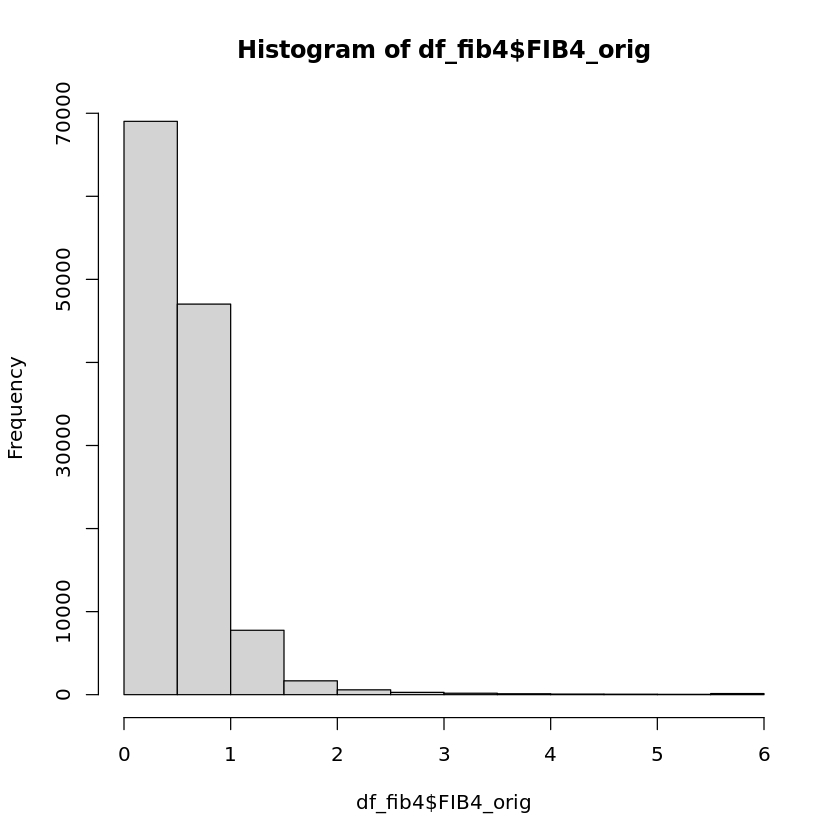

In [92]:
df_fib4 <- df_all %>% select("eid", "AGE", AST = `Aspartate aminotransferase`,
                     ALT = `Alanine aminotransferase`,
                     PLT = `Platelet count`)

df_fib4 <- df_fib4 %>%
  mutate(
    FIB4_orig = (AGE * AST) / (PLT * (ALT * 0.5))
  )

df_fib4 <- adjust_outliers(df_fib4, "FIB4_orig")


# Calculate normalized FIB-4 score (0 to 1)
df_fib4 <- df_fib4 %>%
  mutate(
    FIB4 = (FIB4_orig - min(FIB4_orig, na.rm = TRUE)) / (max(FIB4_orig, na.rm = TRUE) - min(FIB4_orig, na.rm = TRUE))
  )
head(df_fib4)
sum(is.na(df_fib4$FIB4))
summary(df_fib4)
hist(df_fib4$FIB4_orig)

In [93]:
df_apri <- df_all %>% select("eid", "SEX", AST = `Aspartate aminotransferase`,
                     PLT = `Platelet count`)

summary(df_apri)

df_apri <- df_apri %>%
  mutate(
    ULN_AST = case_when(
      SEX == "0" ~ 35,
      SEX == "1" ~ 50,
      TRUE ~ NA_real_
    ),
    APRI_orig = (AST / ULN_AST) / (PLT / 100)
  )
df_apri <- adjust_outliers(df_apri, "APRI_orig")
summary(df_apri)

# Normalize APRI score (0 to 1)
df_apri <- df_apri %>%
  mutate(
    APRI = (APRI_orig - min(APRI_orig, na.rm = TRUE)) / (max(APRI_orig, na.rm = TRUE) - min(APRI_orig, na.rm = TRUE))
  )

# Summary of APRI scores
summary(df_apri$APRI)

      eid          SEX            AST              PLT       
 Min.   :1000004   0:78710   Min.   :  4.00   Min.   :  0.0  
 1st Qu.:1542740   1:48186   1st Qu.: 17.50   1st Qu.:202.0  
 Median :2087086             Median : 21.00   Median :240.0  
 Mean   :2714722             Mean   : 23.74   Mean   :244.5  
 3rd Qu.:3068321             3rd Qu.: 26.00   3rd Qu.:282.0  
 Max.   :9999697             Max.   :251.00   Max.   :649.0  

Columns will be processed in the following order:
APRI_orig 


Column: APRI_orig 
Outliers detected and adjusted to the 99.9th percentile limit:
Number of outliers: 127 
Range of outliers: 3.47692307692308 to Inf 
99.9th percentile limit: 3.476267 


      eid          SEX            AST              PLT           ULN_AST    
 Min.   :1000004   0:78710   Min.   :  4.00   Min.   :  0.0   Min.   :35.0  
 1st Qu.:1542740   1:48186   1st Qu.: 17.50   1st Qu.:202.0   1st Qu.:35.0  
 Median :2087086             Median : 21.00   Median :240.0   Median :35.0  
 Mean   :2714722             Mean   : 23.74   Mean   :244.5   Mean   :40.7  
 3rd Qu.:3068321             3rd Qu.: 26.00   3rd Qu.:282.0   3rd Qu.:50.0  
 Max.   :9999697             Max.   :251.00   Max.   :649.0   Max.   :50.0  
   APRI_orig      
 Min.   :0.02863  
 1st Qu.:0.17164  
 Median :0.22191  
 Mean   :0.27095  
 3rd Qu.:0.29268  
 Max.   :3.47627  

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.04148 0.05606 0.07029 0.07659 1.00000 

## NFS Score

In [94]:
df_nfs <- df_all %>% select(eid, SEX, BMI, AGE, DM, AST = `Aspartate aminotransferase`,
                     ALT = `Alanine aminotransferase`,
                     PLT = `Platelet count`,
                    Albumin)

df_nfs <- df_nfs %>%
  mutate(
    DM_numeric = as.numeric(DM),
    AST_ALT_ratio = AST / ALT,
    NFS_orig = -1.675 + 0.037 * AGE + 0.094 * BMI + 1.13 * ifelse(DM_numeric == 1, 1, 0) + 
          0.99 * AST_ALT_ratio - 0.013 * PLT - 0.66 * Albumin
  )

# Normalize NFS score (0 to 1)
df_nfs <- df_nfs %>%
  mutate(
    NFS = (NFS_orig - min(NFS_orig, na.rm = TRUE)) / (max(NFS_orig, na.rm = TRUE) - min(NFS_orig, na.rm = TRUE))
  )

# Summary of NFS scores
summary(df_nfs$NFS)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.3746  0.4276  0.4376  0.4883  1.0000 

In [95]:
check_zero_to_one <- function(x, column_name) {
  if (!is.numeric(x)) {
    cat(column_name, "is not numeric.\n")
    return(FALSE)
  }
  
  values_in_range <- x >= 0 & x <= 1
  all_in_range <- all(values_in_range, na.rm = TRUE)
  
  cat(column_name, "check:\n")
  cat("  All values between 0 and 1:", all_in_range, "\n")
  cat("  Number of NA values:", sum(is.na(x)), "\n")
  
  if (!all_in_range) {
    out_of_range <- x[!values_in_range & !is.na(x)]
    cat("  Values out of range:", out_of_range, "\n")
  }
  
  cat("\n")
  return(all_in_range)
}

# Check "status" column
status_check <- check_zero_to_one(df_amap$status, "status")

# Check "aMAP" column
amap_check <- check_zero_to_one(df_amap$aMAP, "aMAP")

# Overall result
if (status_check && amap_check) {
  cat("Both 'status' and 'aMAP' columns contain only values between 0 and 1.\n")
} else {
  cat("At least one column contains values outside the range 0 to 1 or is not numeric.\n")
}

status check:
  All values between 0 and 1: TRUE 
  Number of NA values: 0 

aMAP check:
  All values between 0 and 1: TRUE 
  Number of NA values: 204 

Both 'status' and 'aMAP' columns contain only values between 0 and 1.


## Benchmarks together

In [96]:


df_benchmark <- df_amap %>%
  select(eid, aMAP) %>%
  inner_join(df_apri %>% select(eid, APRI), by = "eid") %>%
  inner_join(df_fib4 %>% select(eid, FIB4), by = "eid") %>%
  inner_join(df_nfs %>% select(eid, NFS), by = "eid") %>%
  inner_join(df_early_cirrhosis, by = "eid")

df_benchmark <- merge(df_benchmark, df_y, by="eid")

# Summary of the benchmark dataframe
summary(df_benchmark)
write.csv(df_benchmark, file="HCC/df_benchmark.csv")

      eid               aMAP             APRI              FIB4        
 Min.   :1000004   Min.   :0.0900   Min.   :0.00000   Min.   :0.00000  
 1st Qu.:1542740   1st Qu.:0.4230   1st Qu.:0.04148   1st Qu.:0.05225  
 Median :2087086   Median :0.4950   Median :0.05606   Median :0.08049  
 Mean   :2714722   Mean   :0.4938   Mean   :0.07029   Mean   :0.09645  
 3rd Qu.:3068321   3rd Qu.:0.5660   3rd Qu.:0.07659   3rd Qu.:0.11920  
 Max.   :9999697   Max.   :0.8250   Max.   :1.00000   Max.   :1.00000  
                   NA's   :204                                         
      NFS           cirrhosis           status        
 Min.   :0.0000   Min.   :0.00000   Min.   :0.000000  
 1st Qu.:0.3746   1st Qu.:0.00000   1st Qu.:0.000000  
 Median :0.4276   Median :0.00000   Median :0.000000  
 Mean   :0.4376   Mean   :0.03066   Mean   :0.003507  
 3rd Qu.:0.4883   3rd Qu.:0.00000   3rd Qu.:0.000000  
 Max.   :1.0000   Max.   :1.00000   Max.   :1.000000  
                                       